![alt text](BooleanPandemic.jpg)

### <h1><center>**The Boolean Pandemic**</center></h1>
#### <center> **Machine Learning Project** </center> 

   <center> Maren Leuthner - M20190134
    <br>
    Catarina Palha - M20190156
    <br>
    Mafalda Zúquete - M20190257
    <br>
    Pedro Carvalho - M20190417</center>

### Methodology 

* [1. Introduction](#intro)
    * [1.1 About the data](#data)
    
    
* [2. First Look into the data](#look)
    * [2.1 Adding variables](#var)
    

* [3. Preprocessing](#pre)
    * [3.1 Adding new Variables / Dummy Variables](#dummies)
    * [3.2 Encoding Categorical Values](#encoding)
    * [3.3 Replacing Nulls](#nulls)
    * [3.4 Outliers](#base)


* [4. Testing Section](#testing)
    * [Data Cleaning Tests](#dataclean)
    * [Feature Selection Tests](#featureselc)
    
    
* [5. Modeling](#model)
    * [5.1 Cross Validation](#cross)
    * [5.2 The Model](#chosen)
    * [5.3 Other Models](#others)
    * [5.4 Train the Model](#train)
  
  
* [6. Bagging](#bagging)
 
 
* [7. Tuning Hyperparameters](#hyperp)

 
* [8. Prepare Test Set](#test)


* [9. Keras Experimenation](#keras)


* [10. Results](#result)

### 1. Introduction

On January 1st, 2020, an epidemy was originated in Albuquerque, in New Mexico state, and spread on the
following days to Santa Fe and Taos. It is estimated that the epidemy has already affected more than 1000
people at the end of February, with a mortality rate of more than 50%.


While the conditions of the transmission of the virus is still unknown and there are no certainties of what leads a patient to survive or not to the virus, it seems there are some groups of people more prone to survive than others. The goal of the challenge was to build a predictive model that answers the question:


**"What are the people more likely to survive to the boolean pandemic?"**


As data scientists, our team was asked to analyze and transform the data available and apply different models in order to answer in a more accurate way the defined question above. 
*** The ultimate goal was to design a model that can predict if a patient will survive, or not, to the boolean pandemic. ***


#### 1.1. About the data

`Patient_ID` The unique identifier of the patient<br>
`Family_Case_ID` The family identification<br>
`Severity`The severity of the disease, where 1 is the lowest and 3 the highest severity<br>
`Name`The name of the patient<br>
`Birthday_year`The year of birthday of the patient<br>
`Parents_Siblings_Infected` The number of parents and/or siblings infected<br>
`Partner_Children_Infected`The number of partner and/or children infected<br>
`Medical_Expenses_Family`The medical expenses associated to try to contain the epidemy on the family<br>
`Medical_Tent` The medical tent where the patient is / was lodged<br>
`City` The original city of the patient<br>
`Deceased` Flag if the patient deceased or not with the virus (0 = No, 1 = Yes)<br>

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_classif, chi2, RFECV
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import time
from sklearn.metrics import classification_report, confusion_matrix
from copy import deepcopy

import warnings
warnings.filterwarnings('ignore')

### 2. First Look into the data

In [2]:
train = pd.read_csv('train.csv')

In [3]:
train.head()

,Patient_ID,Family_Case_ID,Severity,Name,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Medical_Tent,City,Deceased
0,1,4696,3,Miss Linda Betty,NaN,0,0,225,NaN,Santa Fe,1
1,2,21436,1,Ms. Ramona Elvira,1966.0,0,1,1663,NaN,Albuquerque,0
2,3,7273,3,Mr. Mario Vernon,1982.0,0,0,221,NaN,Santa Fe,1
3,4,8226,3,Mr. Hector Joe,1997.0,0,0,220,NaN,Santa Fe,1
4,5,19689,3,Ms. Jennie Debra,1994.0,0,0,222,NaN,Santa Fe,0


In [4]:
train.shape

(900, 11)

In [5]:
train.columns

Index(['Patient_ID', 'Family_Case_ID', 'Severity', 'Name', 'Birthday_year',
       'Parents or siblings infected', 'Wife/Husband or children infected',
       'Medical_Expenses_Family', 'Medical_Tent', 'City', 'Deceased'],
      dtype='object')

In [6]:
train.dtypes

Patient_ID                             int64
Family_Case_ID                         int64
Severity                               int64
Name                                  object
Birthday_year                        float64
Parents or siblings infected           int64
Wife/Husband or children infected      int64
Medical_Expenses_Family                int64
Medical_Tent                          object
City                                  object
Deceased                               int64
dtype: object

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 11 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Patient_ID                         900 non-null    int64  
 1   Family_Case_ID                     900 non-null    int64  
 2   Severity                           900 non-null    int64  
 3   Name                               900 non-null    object 
 4   Birthday_year                      723 non-null    float64
 5   Parents or siblings infected       900 non-null    int64  
 6   Wife/Husband or children infected  900 non-null    int64  
 7   Medical_Expenses_Family            900 non-null    int64  
 8   Medical_Tent                       198 non-null    object 
 9   City                               898 non-null    object 
 10  Deceased                           900 non-null    int64  
dtypes: float64(1), int64(7), object(3)
memory usage: 77.5+ KB


In [8]:
train.describe()

,Patient_ID,Family_Case_ID,Severity,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Deceased
count,900.000000,900.000000,900.000000,723.000000,900.000000,900.000000,900.000000,900.000000
mean,450.500000,14305.827778,2.313333,1990.266943,0.380000,0.521111,895.743333,0.614444
std,259.951919,25418.153900,0.834223,14.523335,0.803247,1.098385,1385.829926,0.486997
min,1.000000,345.000000,1.000000,1940.000000,0.000000,0.000000,0.000000,0.000000
25%,225.750000,8203.000000,2.000000,1982.000000,0.000000,0.000000,221.000000,0.000000
50%,450.500000,13593.500000,3.000000,1992.000000,0.000000,0.000000,405.000000,1.000000
75%,675.250000,18906.500000,3.000000,1999.500000,0.000000,1.000000,861.250000,1.000000
max,900.000000,742836.000000,3.000000,2019.000000,6.000000,8.000000,14345.000000,1.000000


In [9]:
for col in ['Severity','Birthday_year','Medical_Tent','City']:
    print(col + ':', train[col].unique())

Severity: [3 1 2]
Birthday_year: [  nan 1966. 1982. 1997. 1994. 1984. 1989. 2000. 2009. 1999. 1991. 2019.
 1964. 2017. 1987. 2011. 1998. 2002. 1992. 1981. 1990. 1978. 2001. 1958.
 1996. 2004. 1962. 1970. 1985. 1965. 2018. 1995. 1956. 2003. 1986. 1971.
 1983. 2005. 1975. 1950. 2016. 2013. 1980. 1979. 2014. 1988. 1993. 1968.
 2006. 1973. 2007. 2012. 1946. 1974. 1972. 2008. 1976. 1961. 1957. 1960.
 1959. 2015. 2010. 1969. 1949. 1955. 1977. 1963. 1954. 1967. 1940.]
Medical_Tent: [nan 'F' 'B' 'A' 'E' 'C' 'D' 'G' 'T']
City: ['Santa Fe' 'Albuquerque' 'Taos' nan]


In [10]:
train.duplicated().any()

False

In [11]:
train.groupby(['Deceased']).count()

,Patient_ID,Family_Case_ID,Severity,Name,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Medical_Tent,City
Deceased,,,,,,,,,,
0,347,347,347,347,295,347,347,347,131,345
1,553,553,553,553,428,553,553,553,67,553


In [12]:
data = train.drop(['Patient_ID','Deceased'],1)
target = train['Deceased']

Only three columns: Severity, Medical_Tent, and City, are categorical variables, and only Name, Medical_Tent, and City are non-numerical.

The values for all variables seem to be within the expected range.

There are null values in the columns: Birthday_year, Medical_Tent, and City.

There are no duplicated lines.

The target classes are not balanced.

### 3. Preprocessing

### 3.1 Add New Variables

`Infected_per_Family` Sum of Parents or sibilings infected and Wife/Husband or children infected<br>
`Maritial_state` 1 if it is married 0 otherwise <br>
`Gender` 1 if it is female 0 otherwise <br>
`Is_young: `0 if the age is lower than 60, 1 otherwise<br>

In [13]:
data['Infected_per_Family'] = data['Parents or siblings infected'] + data['Wife/Husband or children infected']
data['Marital_Status'] = 0
data['Gender'] = 0
data['Title'] = 0
# 2020-60 = 1960
data['Is_young'] = 0
for i in data.index:
    if data['Birthday_year'][i]<=1960:
        data['Is_young'][i] = 0
    elif data['Birthday_year'][i]>1960:
        data['Is_young'][i] = 1
    else:
        data['Is_young'][i] = None

In [14]:
data['Title_Miss'] = data['Name']
data['Title_Ms'] = data['Name']
data['Title_Mrs'] = data['Name']
data['Title_Mr'] = data['Name']
data['Title_Master'] = data['Name']

for i in data.index:
    if data['Name'][i].startswith('Miss'):
        data['Marital_Status'][i] = 0
        data['Gender'][i] = 1
        data['Title_Miss'][i] = 1
        data['Title_Ms'][i] = 0
        data['Title_Mrs'][i] = 0
        data['Title_Mr'][i] = 0
        data['Title_Master'][i] = 0
        
    elif data['Name'][i].startswith('Ms.'):
        data['Marital_Status'][i] = None
        data['Gender'][i] = 1
        data['Title_Miss'][i] = 0
        data['Title_Ms'][i] = 1
        data['Title_Mrs'][i] = 0
        data['Title_Mr'][i] = 0
        data['Title_Master'][i] = 0
        
    elif data['Name'][i].startswith('Mrs.'):
        data['Marital_Status'][i] = 1
        data['Gender'][i] = 1
        data['Title_Miss'][i] = 0
        data['Title_Ms'][i] = 0
        data['Title_Mrs'][i] = 1
        data['Title_Mr'][i] = 0
        data['Title_Master'][i] = 0
        
    elif data['Name'][i].startswith('Mr.'):
        data['Marital_Status'][i] = 1
        data['Gender'][i] = 0
        data['Title_Miss'][i] = 0
        data['Title_Ms'][i] = 0
        data['Title_Mrs'][i] = 0
        data['Title_Mr'][i] = 1
        data['Title_Master'][i] = 0
        
    elif data['Name'][i].startswith('Master'):
        data['Marital_Status'][i] = 0
        data['Gender'][i] = 0
        data['Title_Miss'][i] = 0
        data['Title_Ms'][i] = 0
        data['Title_Mrs'][i] = 0
        data['Title_Mr'][i] = 0
        data['Title_Master'][i] = 1

In [15]:
data[data['Marital_Status'].isnull()].shape

(209, 19)

### 3.2 Encoding Categorical Values

Because the label encoder does not work with null values in the data frame, but we need the variables to be encoded to use a KNNImputer, first we are replacing the all null value in the City column with a dummy, absurd variable, run the encoder, and then turn them back to nulls.

In [16]:
data['City'].mode()[0]

'Santa Fe'

In [17]:
data['City'] = data['City'].fillna(data['City'].mode()[0])

In [19]:
data['City_SantaFe'] = data['City']
data['City_Albuquerque'] = data['City']
data['City_Taos'] = data['City']

for i in data['City'].index:
    if data['City'][i] == 'Santa Fe':
        data['City_SantaFe'][i] = 1
        data['City_Albuquerque'][i] = 0
        data['City_Taos'][i] = 0
    elif data['City'][i] == 'Albuquerque':
        data['City_SantaFe'][i] = 0
        data['City_Albuquerque'][i] = 1
        data['City_Taos'][i] = 0
    elif data['City'][i] == 'Taos':
        data['City_SantaFe'][i] = 0
        data['City_Albuquerque'][i] = 0
        data['City_Taos'][i] = 1

0
Santa Fe
1
Albuquerque
2
Santa Fe
3
Santa Fe
4
Santa Fe
5
Santa Fe
6
Santa Fe
7
Santa Fe
8
Albuquerque
9
Albuquerque
10
Albuquerque
11
Santa Fe
12
Santa Fe
13
Santa Fe
14
Taos
15
Santa Fe
16
Albuquerque
17
Albuquerque
18
Santa Fe
19
Santa Fe
20
Santa Fe
21
Santa Fe
22
Santa Fe
23
Taos
24
Santa Fe
25
Albuquerque
26
Santa Fe
27
Taos
28
Santa Fe
29
Santa Fe
30
Albuquerque
31
Santa Fe
32
Albuquerque
33
Santa Fe
34
Santa Fe
35
Santa Fe
36
Santa Fe
37
Santa Fe
38
Santa Fe
39
Santa Fe
40
Santa Fe
41
Santa Fe
42
Santa Fe
43
Albuquerque
44
Taos
45
Santa Fe
46
Taos
47
Santa Fe
48
Santa Fe
49
Santa Fe
50
Taos
51
Santa Fe
52
Santa Fe
53
Santa Fe
54
Taos
55
Santa Fe
56
Santa Fe
57
Santa Fe
58
Santa Fe
59
Santa Fe
60
Santa Fe
61
Santa Fe
62
Santa Fe
63
Santa Fe
64
Santa Fe
65
Santa Fe
66
Santa Fe
67
Santa Fe
68
Santa Fe
69
Santa Fe
70
Santa Fe
71
Santa Fe
72
Santa Fe
73
Albuquerque
74
Albuquerque
75
Santa Fe
76
Santa Fe
77
Santa Fe
78
Taos
79
Albuquerque
80
Santa Fe
81
Albuquerque
82
Santa Fe
83
S

Santa Fe
741
Santa Fe
742
Albuquerque
743
Santa Fe
744
Santa Fe
745
Santa Fe
746
Santa Fe
747
Albuquerque
748
Santa Fe
749
Albuquerque
750
Santa Fe
751
Albuquerque
752
Albuquerque
753
Albuquerque
754
Santa Fe
755
Taos
756
Santa Fe
757
Santa Fe
758
Santa Fe
759
Santa Fe
760
Albuquerque
761
Santa Fe
762
Santa Fe
763
Albuquerque
764
Santa Fe
765
Santa Fe
766
Santa Fe
767
Albuquerque
768
Santa Fe
769
Albuquerque
770
Taos
771
Taos
772
Santa Fe
773
Santa Fe
774
Santa Fe
775
Santa Fe
776
Albuquerque
777
Santa Fe
778
Santa Fe
779
Santa Fe
780
Santa Fe
781
Taos
782
Santa Fe
783
Albuquerque
784
Santa Fe
785
Albuquerque
786
Santa Fe
787
Santa Fe
788
Santa Fe
789
Santa Fe
790
Santa Fe
791
Albuquerque
792
Albuquerque
793
Santa Fe
794
Albuquerque
795
Albuquerque
796
Santa Fe
797
Santa Fe
798
Santa Fe
799
Santa Fe
800
Santa Fe
801
Santa Fe
802
Santa Fe
803
Santa Fe
804
Santa Fe
805
Santa Fe
806
Santa Fe
807
Santa Fe
808
Santa Fe
809
Santa Fe
810
Santa Fe
811
Santa Fe
812
Albuquerque
813
Santa Fe
814


In [19]:
data.head()

,Family_Case_ID,Severity,Name,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Medical_Tent,City,Infected_per_Family,...,Title,Is_young,Title_Miss,Title_Ms,Title_Mrs,Title_Mr,Title_Master,City_SantaFe,City_Albuquerque,City_Taos
0,4696,3,Miss Linda Betty,NaN,0,0,225,NaN,Santa Fe,0,...,0,NaN,1,0,0,0,0,1,0,0
1,21436,1,Ms. Ramona Elvira,1966.0,0,1,1663,NaN,Albuquerque,1,...,0,1.0,0,1,0,0,0,1,0,0
2,7273,3,Mr. Mario Vernon,1982.0,0,0,221,NaN,Santa Fe,0,...,0,1.0,0,0,0,1,0,1,0,0
3,8226,3,Mr. Hector Joe,1997.0,0,0,220,NaN,Santa Fe,0,...,0,1.0,0,0,0,1,0,1,0,0
4,19689,3,Ms. Jennie Debra,1994.0,0,0,222,NaN,Santa Fe,0,...,0,1.0,0,1,0,0,0,1,0,0


### 3.3 Replacing Nulls

There were null values in the columns Birthday_year, City and Medical_Tent.

- **Birthday_year:** 117 (13% of the data)
- **Medical_Tent:** 702 (78% of the data)
- **City:** 2

And the new column Marital_Status also has null values:

- **Marital_Status:** 209 (23% of the data)

In [20]:
data[data.isnull().any(axis=1)]

,Family_Case_ID,Severity,Name,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Medical_Tent,City,Infected_per_Family,...,Title,Is_young,Title_Miss,Title_Ms,Title_Mrs,Title_Mr,Title_Master,City_SantaFe,City_Albuquerque,City_Taos
0,4696,3,Miss Linda Betty,NaN,0,0,225,NaN,Santa Fe,0,...,0,NaN,1,0,0,0,0,1,0,0
1,21436,1,Ms. Ramona Elvira,1966.0,0,1,1663,NaN,Albuquerque,1,...,0,1.0,0,1,0,0,0,1,0,0
2,7273,3,Mr. Mario Vernon,1982.0,0,0,221,NaN,Santa Fe,0,...,0,1.0,0,0,0,1,0,1,0,0
3,8226,3,Mr. Hector Joe,1997.0,0,0,220,NaN,Santa Fe,0,...,0,1.0,0,0,0,1,0,1,0,0
4,19689,3,Ms. Jennie Debra,1994.0,0,0,222,NaN,Santa Fe,0,...,0,1.0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,6253,3,Ms. Linda Wilcox,1998.0,1,1,344,NaN,Santa Fe,2,...,0,1.0,0,1,0,0,0,1,0,0
896,6483,3,Mr. Haiden Vance,2006.0,0,0,258,NaN,Santa Fe,0,...,0,1.0,0,0,0,1,0,1,0,0
897,981,3,Miss Anaiya Love,1990.0,0,0,214,NaN,Taos,0,...,0,1.0,1,0,0,0,0,1,0,0
898,16418,2,Mr. Robert Williams,1994.0,1,1,812,NaN,Santa Fe,2,...,0,1.0,0,0,0,1,0,1,0,0


In [21]:
data[data.isnull().any(axis=1)].shape

(796, 22)

In [22]:
null_ind = data[data.isnull().any(axis=1)].index

In [23]:
len(null_ind)

796

There are 78% of the data missing on the Medical_Tent column, this is too much therefore this column will be dropped.

Since there are only two null values in the column City, they can simply be replaced using the mode.

In the birthday year column values can be replaced with either the median (since it's less sensible to outliers), or KNNImputer, and for the Is_young columns the mode or KNNImputer can be used, if Birthday_year is not available to compute it.

In [24]:
def null_values(data, method='knn', k=1): 
    # drop the Medical_Tent column 
    data = data.drop(['Medical_Tent'],1)
    
    if method == 'knn':
        imputer = KNNImputer(n_neighbors=k)
        imputer.fit(data)
        data = pd.DataFrame(data=imputer.transform(data),columns=data.columns,index=data.index)
        
    if method == 'stat':
        cols = []
        for col in ['Birthday_year','Is_young','Marital_Status']:
            if col in data.columns:
                cols.append(col)
                
        if 'Birthday_year' in cols:
            data['Birthday_year'] = data['Birthday_year'].fillna(round(data['Birthday_year'].median()))
            for i in data['Is_young'].isna().index:
                if data['Birthday_year'][i]<=1960:
                    data['Is_young'][i] = 0
                elif data['Birthday_year'][i]>1960:
                    data['Is_young'][i] = 1
        elif 'Is_young' in cols:
            data['Is_young'] = data['Is_young'].fillna(float(data['Is_young'].mode()))
            
        if 'Marital_Status' in cols:
            data['Marital_Status'] = data['Marital_Status'].fillna(float(data['Marital_Status'].mode()))
                
    return data

In [25]:
null_values(data.drop(['Name','City'],1),method='stat').iloc[null_ind,:]

,Family_Case_ID,Severity,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Infected_per_Family,Marital_Status,Gender,Title,Is_young,Title_Miss,Title_Ms,Title_Mrs,Title_Mr,Title_Master,City_SantaFe,City_Albuquerque,City_Taos
0,4696,3,1992.0,0,0,225,0,0.0,1,0,1.0,1,0,0,0,0,1,0,0
1,21436,1,1966.0,0,1,1663,1,1.0,1,0,1.0,0,1,0,0,0,1,0,0
2,7273,3,1982.0,0,0,221,0,1.0,0,0,1.0,0,0,0,1,0,1,0,0
3,8226,3,1997.0,0,0,220,0,1.0,0,0,1.0,0,0,0,1,0,1,0,0
4,19689,3,1994.0,0,0,222,0,1.0,1,0,1.0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,6253,3,1998.0,1,1,344,2,1.0,1,0,1.0,0,1,0,0,0,1,0,0
896,6483,3,2006.0,0,0,258,0,1.0,0,0,1.0,0,0,0,1,0,1,0,0
897,981,3,1990.0,0,0,214,0,0.0,1,0,1.0,1,0,0,0,0,1,0,0
898,16418,2,1994.0,1,1,812,2,1.0,0,0,1.0,0,0,0,1,0,1,0,0


### 3.4 Outliers

Since all categorical variables have values within the expected range, we're going to check only the continuous variables for outliers.

In [26]:
data.columns

Index(['Family_Case_ID', 'Severity', 'Name', 'Birthday_year',
       'Parents or siblings infected', 'Wife/Husband or children infected',
       'Medical_Expenses_Family', 'Medical_Tent', 'City',
       'Infected_per_Family', 'Marital_Status', 'Gender', 'Title', 'Is_young',
       'Title_Miss', 'Title_Ms', 'Title_Mrs', 'Title_Mr', 'Title_Master',
       'City_SantaFe', 'City_Albuquerque', 'City_Taos'],
      dtype='object')

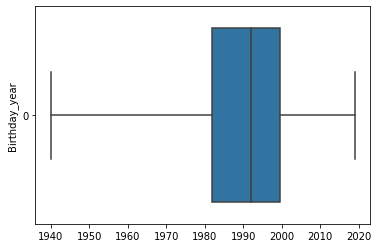

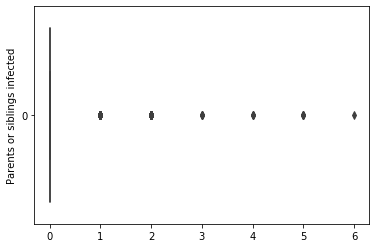

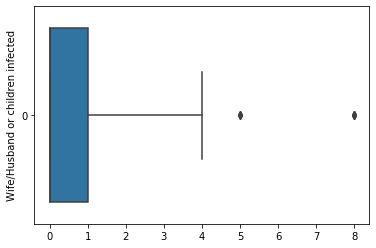

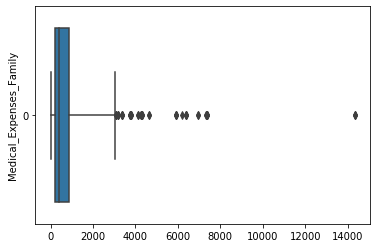

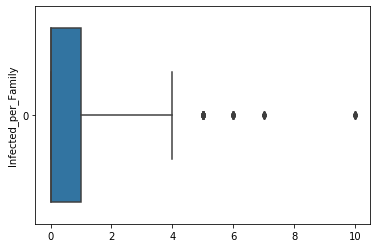

In [27]:
col = ['Birthday_year','Parents or siblings infected','Wife/Husband or children infected','Medical_Expenses_Family','Infected_per_Family']

for c in col:
    sns.boxplot(data=data[c],orient='h',whis=3.5)
    plt.ylabel(c)
    plt.show()

We have outliers in: Family_Case_ID, Parents or siblings infected, Wife/Husband or children infected and Medical_Expenses_Family

In [28]:
def outliers(data, target, std=3, remove=False, pr=False):
    cols = []
    for col in ['Birthday_year','Parents or siblings infected','Wife/Husband or children infected','Medical_Expenses_Family','Infected_per_Family']:
        if col in data.columns:
            cols.append(col)
    
    ind = []
    ind_to_remove = []
    
    if len(cols)>0:
        out = data[cols]
        out = pd.DataFrame(data=StandardScaler().fit_transform(out),index=out.index,columns=out.columns)

        for col in out.columns:
            ind_col = list(out[(out[col]<-std)|(out[col]>std)].index)
            ind += ind_col

        for i in ind:
            if i not in ind_to_remove:
                ind_to_remove.append(i)
            
    if pr == True:
        print(len(ind_to_remove))
    
    if remove == True:
        for i in ind_to_remove:
            data = data.drop(i,0)
            target = target.drop(i,0)
        
        return data, target

In [29]:
outliers(data, target, pr=True)

66


This is around 7% of the data, and so an acceptable number of outliers to remove.

These outliers can be ignored or removed.

### Oversampling

Since the target variable is unbalanced, a hypothesis is to balance the dataset through oversampling. Undersampling was not considered because there's not much data to begin with.

In [30]:
def oversample(data, target):
    X = pd.concat([data, target], axis=1)      

    false = X[X.Deceased==0]
    true = X[X.Deceased==1]    

    false_upsampled = resample(false,
                               replace=True, # sample with replacement
                               n_samples=len(medium), # match number in majority class
                               random_state=27) # reproducible results        

    upsampled = pd.concat([false_upsampled, true])

    data = upsampled.drop(['Deceased'],1)
    target = upsampled['Deceased']   

    return data, target

In [37]:
def show_results(df, models, method = 'knn', k = 1, remove = False, std = 3, oversampling = False, scaler = MinMaxScaler(), parameters = None,features=False):
    """
    Receive an empty dataframe and the different models and call the function avg_score
    """
    count = 0
    # for each model passed as argument
    for model in models:
        parameter_space = None
        if parameters != None:
            parameter_space = parameters[models.index(model)]
            
        if parameter_space == None:
            grid_search = False
        else:
            grid_search = True
                
        print('----------------------------------')
        # obtain the results provided by avg_score
        time, avg_train, avg_test, avg_iter = avg_score(model, method = method, k = k, remove = remove, std = std, oversampling = oversampling, grid_search = grid_search, scaler = scaler, parameters = parameter_space, features = features)
        # store the results in the right row
        df.iloc[count] = time, avg_train, avg_test, avg_iter
        count+=1

    return df

In [38]:
model_simple = MLPClassifier(hidden_layer_sizes=(1,),max_iter=1000,random_state=0)
model_medium = MLPClassifier(hidden_layer_sizes=(50,50),max_iter=1000,random_state=0)
model_complex = MLPClassifier(hidden_layer_sizes=(100,100,100),max_iter=1000,random_state=0)

In [39]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'],index=['Simple','Medium','Complex'])
show_results(df,[model_simple,model_medium,model_complex])

----------------------------------
              precision    recall  f1-score   support

           0       0.74      0.65      0.69        69
           1       0.80      0.86      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.75      0.76       180
weighted avg       0.78      0.78      0.77       180

[[45 24]
 [16 95]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        69
           1       0.62      1.00      0.76       111

    accuracy                           0.62       180
   macro avg       0.31      0.50      0.38       180
weighted avg       0.38      0.62      0.47       180

[[  0  69]
 [  0 111]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        69
           1       0.62      1.00      0.76       111

    accuracy                           0.62       180
   macro avg       0.31      0.50      0.38       1

,Time,Train,Test,Iterations
Simple,0.898+/-0.2,0.729+/-0.09,0.724+/-0.09,850.4+/-183.3
Medium,6.529+/-1.13,0.86+/-0.01,0.812+/-0.03,561.8+/-93.2
Complex,5.753+/-1.65,0.872+/-0.01,0.804+/-0.03,249.4+/-70.8


Performs better with a medium sized network.

In [43]:
model_relu = MLPClassifier(activation='relu',max_iter=1000,random_state=0)
model_logistic = MLPClassifier(activation='logistic',max_iter=1000,random_state=0)
model_tanh = MLPClassifier(activation='tanh',max_iter=1000,random_state=0)
model_identity = MLPClassifier(activation='identity',max_iter=1000,random_state=0)

In [44]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'],index=['relu','logistic','tanh','identity'])
show_results(df,[model_relu,model_logistic,model_tanh,model_identity])

----------------------------------
              precision    recall  f1-score   support

           0       0.79      0.72      0.76        69
           1       0.84      0.88      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80      0.81       180
weighted avg       0.82      0.82      0.82       180

[[50 19]
 [13 98]]
              precision    recall  f1-score   support

           0       0.72      0.62      0.67        69
           1       0.78      0.85      0.81       111

    accuracy                           0.76       180
   macro avg       0.75      0.74      0.74       180
weighted avg       0.76      0.76      0.76       180

[[43 26]
 [17 94]]
              precision    recall  f1-score   support

           0       0.82      0.71      0.76        69
           1       0.83      0.90      0.87       111

    accuracy                           0.83       180
   macro avg       0.82      0.81      0.81       180
w

,Time,Train,Test,Iterations
relu,6.991+/-1.24,0.852+/-0.01,0.813+/-0.03,793.0+/-188.7
logistic,1.426+/-0.32,0.798+/-0.0,0.782+/-0.02,220.4+/-13.0
tanh,1.713+/-1.68,0.811+/-0.02,0.782+/-0.02,266.4+/-249.7
identity,0.569+/-0.07,0.799+/-0.01,0.78+/-0.03,126.6+/-14.2


Performs better with activation function relu.

In [45]:
model_lr_big = MLPClassifier(solver='sgd',learning_rate_init=0.5,max_iter=1000,random_state=0)
model_lr_medium = MLPClassifier(solver='sgd',learning_rate_init=0.001,max_iter=1000,random_state=0)
model_lr_small = MLPClassifier(solver='sgd',learning_rate_init=0.000001,max_iter=1000,random_state=0)

In [46]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'],index=['big','medium','small'])
show_results(df,[model_lr_big,model_lr_medium,model_lr_small])

----------------------------------
              precision    recall  f1-score   support

           0       0.66      0.84      0.74        69
           1       0.88      0.73      0.80       111

    accuracy                           0.77       180
   macro avg       0.77      0.79      0.77       180
weighted avg       0.80      0.77      0.78       180

[[58 11]
 [30 81]]
              precision    recall  f1-score   support

           0       0.78      0.61      0.68        69
           1       0.79      0.89      0.84       111

    accuracy                           0.78       180
   macro avg       0.78      0.75      0.76       180
weighted avg       0.78      0.78      0.78       180

[[42 27]
 [12 99]]
              precision    recall  f1-score   support

           0       0.77      0.70      0.73        69
           1       0.82      0.87      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.78      0.79       180
w

,Time,Train,Test,Iterations
big,0.422+/-0.05,0.841+/-0.02,0.802+/-0.02,79.4+/-10.5
medium,1.949+/-0.44,0.787+/-0.0,0.783+/-0.01,297.0+/-11.0
small,0.102+/-0.0,0.348+/-0.01,0.347+/-0.02,12.0+/-0.0


Performs better with a big learning rate.

In [47]:
model_lr_big_inv = MLPClassifier(solver='sgd',learning_rate_init=0.5,learning_rate='invscaling',max_iter=1000,random_state=0)
model_lr_medium_inv = MLPClassifier(solver='sgd',learning_rate_init=0.001,learning_rate='invscaling',max_iter=1000,random_state=0)
model_lr_big_adap = MLPClassifier(solver='sgd',learning_rate_init=0.5,learning_rate='adaptive',max_iter=1000,random_state=0)
model_lr_medium_adap = MLPClassifier(solver='sgd',learning_rate_init=0.001,learning_rate='adaptive',max_iter=1000,random_state=0)

In [49]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'],index=['big_inv','medium_inv','big_adap','medium_adap'])
show_results(df,[model_lr_big_inv,model_lr_medium_inv,model_lr_big_adap,model_lr_medium_adap])

----------------------------------
              precision    recall  f1-score   support

           0       0.73      0.68      0.71        69
           1       0.81      0.85      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.77       180
weighted avg       0.78      0.78      0.78       180

[[47 22]
 [17 94]]
              precision    recall  f1-score   support

           0       0.71      0.68      0.70        69
           1       0.81      0.83      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.76       180
weighted avg       0.77      0.77      0.77       180

[[47 22]
 [19 92]]
              precision    recall  f1-score   support

           0       0.71      0.68      0.70        69
           1       0.81      0.83      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.76       180
w

,Time,Train,Test,Iterations
big_inv,0.151+/-0.16,0.789+/-0.01,0.786+/-0.01,26.0+/-26.0
medium_inv,0.173+/-0.02,0.396+/-0.01,0.384+/-0.02,31.2+/-2.3
big_adap,1.87+/-0.34,0.851+/-0.01,0.806+/-0.03,283.0+/-30.2
medium_adap,2.943+/-0.13,0.787+/-0.0,0.783+/-0.01,352.0+/-11.0


With an adaptive learning rate the model performs better.

In [50]:
model_lr_big = MLPClassifier(solver='adam',learning_rate_init=0.5,max_iter=1000,random_state=0)
model_lr_medium = MLPClassifier(solver='adam',learning_rate_init=0.001,max_iter=1000,random_state=0)
model_lr_small = MLPClassifier(solver='adam',learning_rate_init=0.000001,max_iter=1000,random_state=0)

In [51]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'],index=['big','medium','small'])
show_results(df,[model_lr_big,model_lr_medium,model_lr_small])

----------------------------------
              precision    recall  f1-score   support

           0       0.79      0.61      0.69        69
           1       0.79      0.90      0.84       111

    accuracy                           0.79       180
   macro avg       0.79      0.75      0.76       180
weighted avg       0.79      0.79      0.78       180

[[ 42  27]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.76      0.59      0.67        69
           1       0.78      0.88      0.83       111

    accuracy                           0.77       180
   macro avg       0.77      0.74      0.75       180
weighted avg       0.77      0.77      0.77       180

[[41 28]
 [13 98]]
              precision    recall  f1-score   support

           0       0.91      0.57      0.70        69
           1       0.78      0.96      0.86       111

    accuracy                           0.81       180
   macro avg       0.84      0.76      0.78       1

,Time,Train,Test,Iterations
big,0.256+/-0.04,0.812+/-0.01,0.799+/-0.02,51.4+/-7.1
medium,5.75+/-1.19,0.852+/-0.01,0.813+/-0.03,793.0+/-188.7
small,0.102+/-0.0,0.348+/-0.01,0.347+/-0.02,12.0+/-0.0


medium learning rate has the best performance.

In [60]:
model_sgd = MLPClassifier(solver='sgd',learning_rate_init=0.5,learning_rate='adaptive',max_iter=1000,random_state=0)
model_adam = MLPClassifier(solver='adam',learning_rate_init=0.001,max_iter=1000,random_state=0)
model_lbfgs = MLPClassifier(solver='lbfgs',max_iter=5000,random_state=0)

In [61]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'],index=['sgd','adam','lbfgs'])
show_results(df,[model_sgd,model_adam,model_lbfgs])

----------------------------------
              precision    recall  f1-score   support

           0       0.81      0.70      0.75        69
           1       0.83      0.90      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80      0.81       180
weighted avg       0.82      0.82      0.82       180

[[ 48  21]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.71      0.64      0.67        69
           1       0.79      0.84      0.81       111

    accuracy                           0.76       180
   macro avg       0.75      0.74      0.74       180
weighted avg       0.76      0.76      0.76       180

[[44 25]
 [18 93]]
              precision    recall  f1-score   support

           0       0.77      0.70      0.73        69
           1       0.82      0.87      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.78      0.79       1

,Time,Train,Test,Iterations
sgd,2.119+/-0.19,0.851+/-0.01,0.806+/-0.03,283.0+/-30.2
adam,6.147+/-1.62,0.852+/-0.01,0.813+/-0.03,793.0+/-188.7
lbfgs,20.548+/-1.91,0.928+/-0.02,0.764+/-0.03,4070.4+/-379.7


In [184]:
model_saga_elasticnet_0_9 = LogisticRegression(penalty='elasticnet',solver='saga',l1_ratio=0.9)
model_saga_elasticnet_0_8 = LogisticRegression(penalty='elasticnet',solver='saga',l1_ratio=0.8)
model_saga_elasticnet_0_7 = LogisticRegression(penalty='elasticnet',solver='saga',l1_ratio=0.7)
model_saga_elasticnet_0_6 = LogisticRegression(penalty='elasticnet',solver='saga',l1_ratio=0.6)
model_saga_elasticnet_0_5 = LogisticRegression(penalty='elasticnet',solver='saga',l1_ratio=0.5)
model_saga_elasticnet_0_4 = LogisticRegression(penalty='elasticnet',solver='saga',l1_ratio=0.4)
model_saga_elasticnet_0_3 = LogisticRegression(penalty='elasticnet',solver='saga',l1_ratio=0.3)
model_saga_elasticnet_0_2 = LogisticRegression(penalty='elasticnet',solver='saga',l1_ratio=0.2)
model_saga_elasticnet_0_1 = LogisticRegression(penalty='elasticnet',solver='saga',l1_ratio=0.1)

In [185]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=[0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1])
show_results(df,[model_saga_elasticnet_0_9,model_saga_elasticnet_0_8,model_saga_elasticnet_0_7,model_saga_elasticnet_0_6,model_saga_elasticnet_0_5,model_saga_elasticnet_0_4,model_saga_elasticnet_0_3,model_saga_elasticnet_0_2,model_saga_elasticnet_0_1])

----------------------------------
              precision    recall  f1-score   support

           0       0.73      0.67      0.70        69
           1       0.80      0.85      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[46 23]
 [17 94]]
              precision    recall  f1-score   support

           0       0.71      0.72      0.72        69
           1       0.83      0.82      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.78      0.78      0.78       180

[[50 19]
 [20 91]]
              precision    recall  f1-score   support

           0       0.70      0.68      0.69        69
           1       0.81      0.82      0.81       111

    accuracy                           0.77       180
   macro avg       0.75      0.75      0.75       180
w

              precision    recall  f1-score   support

           0       0.82      0.66      0.73        70
           1       0.81      0.91      0.85       110

    accuracy                           0.81       180
   macro avg       0.81      0.78      0.79       180
weighted avg       0.81      0.81      0.81       180

[[ 46  24]
 [ 10 100]]
----------------------------------
              precision    recall  f1-score   support

           0       0.72      0.68      0.70        69
           1       0.81      0.84      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[47 22]
 [18 93]]
              precision    recall  f1-score   support

           0       0.71      0.71      0.71        69
           1       0.82      0.82      0.82       111

    accuracy                           0.78       180
   macro avg       0.76      0.76      0.76       1

,Time,Train,Test
0.9,0.02+/-0.01,0.794+/-0.01,0.78+/-0.01
0.8,0.019+/-0.01,0.794+/-0.01,0.778+/-0.02
0.7,0.023+/-0.01,0.795+/-0.01,0.777+/-0.02
0.6,0.026+/-0.0,0.796+/-0.0,0.777+/-0.02
0.5,0.03+/-0.0,0.796+/-0.0,0.777+/-0.02
0.4,0.022+/-0.0,0.797+/-0.0,0.777+/-0.02
0.3,0.02+/-0.0,0.797+/-0.0,0.776+/-0.02
0.2,0.018+/-0.0,0.797+/-0.0,0.777+/-0.02
0.1,0.016+/-0.0,0.798+/-0.0,0.776+/-0.02


l1_ratio of 0.9 is slightly better.

In [186]:
model_saga_l1 = LogisticRegression(penalty='l1',solver='saga')
model_saga_l2 = LogisticRegression(penalty='l2',solver='saga')
model_saga_elasticnet_0_9 = LogisticRegression(penalty='elasticnet',solver='saga',l1_ratio=0.9)
model_saga_none = LogisticRegression(penalty='none',solver='saga')

In [187]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=['l1','l2','elasticnet_0.9','none'])
show_results(df,[model_saga_l1,model_saga_l2,model_saga_elasticnet_0_9,model_saga_none])

----------------------------------
              precision    recall  f1-score   support

           0       0.73      0.67      0.70        69
           1       0.80      0.85      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[46 23]
 [17 94]]
              precision    recall  f1-score   support

           0       0.71      0.72      0.72        69
           1       0.83      0.82      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.78      0.78      0.78       180

[[50 19]
 [20 91]]
              precision    recall  f1-score   support

           0       0.70      0.68      0.69        69
           1       0.81      0.82      0.81       111

    accuracy                           0.77       180
   macro avg       0.75      0.75      0.75       180
w

,Time,Train,Test
l1,0.024+/-0.0,0.795+/-0.0,0.78+/-0.01
l2,0.013+/-0.0,0.798+/-0.0,0.777+/-0.02
elasticnet_0.9,0.02+/-0.0,0.794+/-0.01,0.78+/-0.01
none,0.025+/-0.01,0.8+/-0.0,0.779+/-0.02


elasticnet with l1_ratio of 0.9 or l1 is slightly better.

In [188]:
model_newton_none = LogisticRegression(penalty='none',solver='newton-cg')
model_lbfgs_none = LogisticRegression(penalty='none',solver='lbfgs')
model_liblinear_l1 = LogisticRegression(penalty='l1',solver='liblinear')
model_sag_none = LogisticRegression(penalty='none',solver='sag')
model_saga_elasticnet_0_9 = LogisticRegression(penalty='elasticnet',solver='saga',l1_ratio=0.9)
model_saga_l1 = LogisticRegression(penalty='l1',solver='saga')

In [189]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=['newton','lbfgs','liblinear','sag_none','elasticnet_0.9','saga_l1'])
show_results(df,[model_newton_none,model_lbfgs_none,model_liblinear_l2,model_sag_none,model_saga_elasticnet_0_9,model_saga_l1])

----------------------------------
              precision    recall  f1-score   support

           0       0.72      0.68      0.70        69
           1       0.81      0.84      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[47 22]
 [18 93]]
              precision    recall  f1-score   support

           0       0.70      0.68      0.69        69
           1       0.81      0.82      0.81       111

    accuracy                           0.77       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.77      0.77      0.77       180

[[47 22]
 [20 91]]
              precision    recall  f1-score   support

           0       0.71      0.67      0.69        69
           1       0.80      0.83      0.81       111

    accuracy                           0.77       180
   macro avg       0.75      0.75      0.75       180
w

              precision    recall  f1-score   support

           0       0.81      0.66      0.72        70
           1       0.80      0.90      0.85       110

    accuracy                           0.81       180
   macro avg       0.81      0.78      0.79       180
weighted avg       0.81      0.81      0.80       180

[[46 24]
 [11 99]]
----------------------------------
              precision    recall  f1-score   support

           0       0.73      0.67      0.70        69
           1       0.80      0.85      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[46 23]
 [17 94]]
              precision    recall  f1-score   support

           0       0.71      0.72      0.72        69
           1       0.83      0.82      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
w

,Time,Train,Test
newton,0.047+/-0.0,0.799+/-0.0,0.779+/-0.02
lbfgs,0.05+/-0.01,0.799+/-0.0,0.779+/-0.02
liblinear,0.002+/-0.0,0.798+/-0.0,0.777+/-0.02
sag_none,0.021+/-0.01,0.799+/-0.0,0.779+/-0.02
elasticnet_0.9,0.021+/-0.0,0.794+/-0.01,0.78+/-0.01
saga_l1,0.022+/-0.01,0.795+/-0.0,0.78+/-0.01


saga performs slightly better.

In [190]:
model_0 = LogisticRegression(fit_intercept=False)
model_1 = LogisticRegression(fit_intercept=True)

In [191]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=['no intercept','intercept'])
show_results(df,[model_0,model_1])

----------------------------------
              precision    recall  f1-score   support

           0       0.72      0.68      0.70        69
           1       0.81      0.84      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[47 22]
 [18 93]]
              precision    recall  f1-score   support

           0       0.72      0.70      0.71        69
           1       0.81      0.83      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[48 21]
 [19 92]]
              precision    recall  f1-score   support

           0       0.69      0.68      0.69        69
           1       0.80      0.81      0.81       111

    accuracy                           0.76       180
   macro avg       0.75      0.75      0.75       180
w

,Time,Train,Test
no intercept,0.025+/-0.0,0.799+/-0.0,0.778+/-0.02
intercept,0.031+/-0.0,0.798+/-0.0,0.777+/-0.02


Inconclusive.

In [192]:
model_0 = LogisticRegression(class_weight=None)
model_1 = LogisticRegression(class_weight='balanced')

In [193]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=['not balanced','balanced'])
show_results(df,[model_0,model_1])

----------------------------------
              precision    recall  f1-score   support

           0       0.72      0.68      0.70        69
           1       0.81      0.84      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[47 22]
 [18 93]]
              precision    recall  f1-score   support

           0       0.72      0.70      0.71        69
           1       0.81      0.83      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[48 21]
 [19 92]]
              precision    recall  f1-score   support

           0       0.69      0.67      0.68        69
           1       0.80      0.81      0.80       111

    accuracy                           0.76       180
   macro avg       0.74      0.74      0.74       180
w

,Time,Train,Test
not balanced,0.033+/-0.0,0.798+/-0.0,0.777+/-0.02
balanced,0.032+/-0.01,0.788+/-0.0,0.773+/-0.01


Not balanced performs better.

In [194]:
model_auto = LogisticRegression(multi_class='auto')
model_ovr = LogisticRegression(multi_class='ovr')
model_multinomial = LogisticRegression(multi_class='multinomial')

In [195]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=['auto','ovr','multinomial'])
show_results(df,[model_auto,model_ovr,model_multinomial])

----------------------------------
              precision    recall  f1-score   support

           0       0.72      0.68      0.70        69
           1       0.81      0.84      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[47 22]
 [18 93]]
              precision    recall  f1-score   support

           0       0.72      0.70      0.71        69
           1       0.81      0.83      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[48 21]
 [19 92]]
              precision    recall  f1-score   support

           0       0.69      0.67      0.68        69
           1       0.80      0.81      0.80       111

    accuracy                           0.76       180
   macro avg       0.74      0.74      0.74       180
w

,Time,Train,Test
auto,0.032+/-0.0,0.798+/-0.0,0.777+/-0.02
ovr,0.031+/-0.0,0.798+/-0.0,0.777+/-0.02
multinomial,0.026+/-0.0,0.798+/-0.0,0.779+/-0.02


Multinomial performs better.

In [196]:
model_0 = LogisticRegression(warm_start=False)
model_1 = LogisticRegression(warm_start=True)

In [197]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=['no warm start','warm start'])
show_results(df,[model_0,model_1])

----------------------------------
              precision    recall  f1-score   support

           0       0.72      0.68      0.70        69
           1       0.81      0.84      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[47 22]
 [18 93]]
              precision    recall  f1-score   support

           0       0.72      0.70      0.71        69
           1       0.81      0.83      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[48 21]
 [19 92]]
              precision    recall  f1-score   support

           0       0.69      0.67      0.68        69
           1       0.80      0.81      0.80       111

    accuracy                           0.76       180
   macro avg       0.74      0.74      0.74       180
w

,Time,Train,Test
no warm start,0.033+/-0.0,0.798+/-0.0,0.777+/-0.02
warm start,0.038+/-0.01,0.798+/-0.0,0.777+/-0.02


Inconclusive.

In [198]:
parameter_space = {
    'C':[0.1,1],
    'solver':['newton-cg','lbfgs','saga','sag'],
    'penalty':['none','elasticnet','l1','l2'],
    'l1_ratio':[0.9],
    'fit_intercept':[True,False],
    'multi_class':['multinomial'],
    'warm_start':[True,False]
}

model = LogisticRegression()

## Tests

### Data Cleaning and Scaling

Given that there are so many alternatives on how to clean and scale the data, they're going to be tested against each other.

***Normalizing the data***

In [199]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],parameters=[parameter_space])

----------------------------------
{'C': 1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.72      0.68      0.70        69
           1       0.81      0.84      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[47 22]
 [18 93]]
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'none', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.70      0.68      0.69        69
           1       0.81      0.82      0.81       111

    accuracy                           0.77       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.77      0.77      0.77       180

[[47 22]
 [20 9

,Time,Train,Test
model,4.473+/-0.56,0.797+/-0.01,0.777+/-0.01


In [200]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],scaler=StandardScaler(),parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.72      0.67      0.69        69
           1       0.80      0.84      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.76       180
weighted avg       0.77      0.77      0.77       180

[[46 23]
 [18 93]]
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'none', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.70      0.68      0.69        69
           1       0.81      0.82      0.81       111

    accuracy                           0.77       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.77      0.77      0.77       180

[[47 22]

,Time,Train,Test
model,5.012+/-0.71,0.798+/-0.01,0.772+/-0.01


In [201]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],scaler=RobustScaler(),parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': False, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'elasticnet', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.74      0.70      0.72        69
           1       0.82      0.85      0.83       111

    accuracy                           0.79       180
   macro avg       0.78      0.77      0.77       180
weighted avg       0.79      0.79      0.79       180

[[48 21]
 [17 94]]
{'C': 0.1, 'fit_intercept': False, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l1', 'solver': 'saga', 'warm_start': False}
              precision    recall  f1-score   support

           0       0.71      0.68      0.70        69
           1       0.81      0.83      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.76       180
weighted avg       0.77      0.77      0.77       180

[[47 22]


,Time,Train,Test
model,7.056+/-0.93,0.8+/-0.01,0.79+/-0.02


In [202]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],scaler=MaxAbsScaler(),parameters=[parameter_space])

----------------------------------
{'C': 1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.73      0.70      0.71        69
           1       0.82      0.84      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.78      0.78      0.78       180

[[48 21]
 [18 93]]
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'none', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.70      0.68      0.69        69
           1       0.81      0.82      0.81       111

    accuracy                           0.77       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.77      0.77      0.77       180

[[47 22]
 

,Time,Train,Test
model,5.609+/-0.71,0.797+/-0.01,0.778+/-0.01


In [203]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],remove=True,parameters=[parameter_space])

----------------------------------
{'C': 1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.70      0.68      0.69        69
           1       0.81      0.82      0.81       111

    accuracy                           0.77       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.77      0.77      0.77       180

[[47 22]
 [20 91]]
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.69      0.68      0.69        69
           1       0.80      0.81      0.81       111

    accuracy                           0.76       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.76      0.76      0.76       180

[[47 22]
 [2

,Time,Train,Test
model,4.874+/-0.71,0.797+/-0.01,0.776+/-0.02


In [204]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],remove=True,scaler=StandardScaler(),parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.71      0.68      0.70        69
           1       0.81      0.83      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.76       180
weighted avg       0.77      0.77      0.77       180

[[47 22]
 [19 92]]
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'elasticnet', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.68      0.70      0.69        69
           1       0.81      0.79      0.80       111

    accuracy                           0.76       180
   macro avg       0.74      0.74      0.74       180
weighted avg       0.76      0.76      0.76       180

[[48 21

,Time,Train,Test
model,4.901+/-0.66,0.793+/-0.01,0.77+/-0.02


In [205]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],remove=True,scaler=RobustScaler(),parameters=[parameter_space])

----------------------------------
{'C': 1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l1', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.71      0.68      0.70        69
           1       0.81      0.83      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.76       180
weighted avg       0.77      0.77      0.77       180

[[47 22]
 [19 92]]
{'C': 1, 'fit_intercept': False, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'elasticnet', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.68      0.70      0.69        69
           1       0.81      0.79      0.80       111

    accuracy                           0.76       180
   macro avg       0.74      0.74      0.74       180
weighted avg       0.76      0.76      0.76       180

[[48 21]
 [23 8

,Time,Train,Test
model,6.054+/-0.72,0.796+/-0.0,0.774+/-0.02


In [206]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],remove=True,scaler=MaxAbsScaler(),parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.73      0.68      0.71        69
           1       0.81      0.85      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.77       180
weighted avg       0.78      0.78      0.78       180

[[47 22]
 [17 94]]
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.69      0.68      0.69        69
           1       0.80      0.81      0.81       111

    accuracy                           0.76       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.76      0.76      0.76       180

[[47 22]
 

,Time,Train,Test
model,4.649+/-0.23,0.796+/-0.01,0.783+/-0.02


In [207]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],remove=True,std=4,parameters=[parameter_space])

----------------------------------
{'C': 1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.71      0.67      0.69        69
           1       0.80      0.83      0.81       111

    accuracy                           0.77       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.76      0.77      0.77       180

[[46 23]
 [19 92]]
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.70      0.68      0.69        69
           1       0.81      0.82      0.81       111

    accuracy                           0.77       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.77      0.77      0.77       180

[[47 22]
 [2

,Time,Train,Test
model,3.961+/-0.53,0.794+/-0.01,0.783+/-0.02


In [208]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],remove=True,std=4,scaler=StandardScaler(),parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'none', 'solver': 'sag', 'warm_start': False}
              precision    recall  f1-score   support

           0       0.71      0.67      0.69        69
           1       0.80      0.83      0.81       111

    accuracy                           0.77       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.76      0.77      0.77       180

[[46 23]
 [19 92]]
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l1', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.69      0.68      0.69        69
           1       0.80      0.81      0.81       111

    accuracy                           0.76       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.76      0.76      0.76       180

[[47 22]
 [21 90]]

,Time,Train,Test
model,3.417+/-0.41,0.795+/-0.01,0.778+/-0.02


In [209]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],remove=True,std=4,scaler=RobustScaler(),parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'none', 'solver': 'lbfgs', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.71      0.67      0.69        69
           1       0.80      0.83      0.81       111

    accuracy                           0.77       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.76      0.77      0.77       180

[[46 23]
 [19 92]]
{'C': 0.1, 'fit_intercept': False, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l1', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.68      0.68      0.68        69
           1       0.80      0.80      0.80       111

    accuracy                           0.76       180
   macro avg       0.74      0.74      0.74       180
weighted avg       0.76      0.76      0.76       180

[[47 22]
 [22 89

,Time,Train,Test
model,4.457+/-0.43,0.791+/-0.0,0.772+/-0.02


In [210]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],remove=True,std=4,scaler=MaxAbsScaler(),parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': False, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'none', 'solver': 'lbfgs', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.71      0.67      0.69        69
           1       0.80      0.83      0.81       111

    accuracy                           0.77       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.76      0.77      0.77       180

[[46 23]
 [19 92]]
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'elasticnet', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.71      0.68      0.70        69
           1       0.81      0.83      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.76       180
weighted avg       0.77      0.77      0.77       180

[[47 22]

,Time,Train,Test
model,3.989+/-0.13,0.795+/-0.0,0.782+/-0.02


In [211]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=2,parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'none', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.72      0.67      0.69        69
           1       0.80      0.84      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.76       180
weighted avg       0.77      0.77      0.77       180

[[46 23]
 [18 93]]
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'none', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.70      0.71      0.71        69
           1       0.82      0.81      0.81       111

    accuracy                           0.77       180
   macro avg       0.76      0.76      0.76       180
weighted avg       0.77      0.77      0.77       180

[[49 2

,Time,Train,Test
model,3.864+/-0.61,0.793+/-0.01,0.779+/-0.01


In [212]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=2,scaler=StandardScaler(),parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'none', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.72      0.67      0.69        69
           1       0.80      0.84      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.76       180
weighted avg       0.77      0.77      0.77       180

[[46 23]
 [18 93]]
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'none', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.70      0.71      0.71        69
           1       0.82      0.81      0.81       111

    accuracy                           0.77       180
   macro avg       0.76      0.76      0.76       180
weighted avg       0.77      0.77      0.77       180

[[49 2

,Time,Train,Test
model,5.222+/-1.05,0.795+/-0.0,0.778+/-0.02


In [213]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=2,scaler=RobustScaler(),parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'none', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.72      0.67      0.69        69
           1       0.80      0.84      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.76       180
weighted avg       0.77      0.77      0.77       180

[[46 23]
 [18 93]]
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'none', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.70      0.72      0.71        69
           1       0.83      0.81      0.82       111

    accuracy                           0.78       180
   macro avg       0.76      0.77      0.77       180
weighted avg       0.78      0.78      0.78       180

[[50 19]
 [

,Time,Train,Test
model,6.211+/-0.45,0.797+/-0.01,0.787+/-0.02


In [214]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=2,scaler=MaxAbsScaler(),parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'none', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.72      0.67      0.69        69
           1       0.80      0.84      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.76       180
weighted avg       0.77      0.77      0.77       180

[[46 23]
 [18 93]]
{'C': 0.1, 'fit_intercept': False, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'none', 'solver': 'lbfgs', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.70      0.71      0.71        69
           1       0.82      0.81      0.81       111

    accuracy                           0.77       180
   macro avg       0.76      0.76      0.76       180
weighted avg       0.77      0.77      0.77       180

[[49 20]


,Time,Train,Test
model,5.056+/-0.51,0.796+/-0.01,0.779+/-0.01


In [215]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=2,remove=True,parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'elasticnet', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.74      0.67      0.70        69
           1       0.81      0.86      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.77       180
weighted avg       0.78      0.78      0.78       180

[[46 23]
 [16 95]]
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.69      0.68      0.69        69
           1       0.80      0.81      0.81       111

    accuracy                           0.76       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.76      0.76      0.76       180

[[47 22

,Time,Train,Test
model,3.98+/-0.37,0.795+/-0.0,0.778+/-0.02


In [216]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=2,remove=True,scaler=StandardScaler(),parameters=[parameter_space])

----------------------------------
{'C': 1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'elasticnet', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.70      0.68      0.69        69
           1       0.81      0.82      0.81       111

    accuracy                           0.77       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.77      0.77      0.77       180

[[47 22]
 [20 91]]
{'C': 1, 'fit_intercept': False, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'elasticnet', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.67      0.81      0.73        69
           1       0.86      0.75      0.80       111

    accuracy                           0.77       180
   macro avg       0.77      0.78      0.77       180
weighted avg       0.79      0.77      0.78       180

[[56 13

,Time,Train,Test
model,5.033+/-0.85,0.792+/-0.0,0.774+/-0.02


In [217]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=2,remove=True,scaler=RobustScaler(),parameters=[parameter_space])

----------------------------------
{'C': 1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'elasticnet', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.71      0.68      0.70        69
           1       0.81      0.83      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.76       180
weighted avg       0.77      0.77      0.77       180

[[47 22]
 [19 92]]
{'C': 0.1, 'fit_intercept': False, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'none', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.68      0.71      0.70        69
           1       0.81      0.79      0.80       111

    accuracy                           0.76       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.76      0.76      0.76       180

[[49 20]
 [

,Time,Train,Test
model,5.579+/-0.39,0.792+/-0.01,0.774+/-0.02


In [218]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=2,remove=True,scaler=MaxAbsScaler(),parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.73      0.68      0.71        69
           1       0.81      0.85      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.77       180
weighted avg       0.78      0.78      0.78       180

[[47 22]
 [17 94]]
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.69      0.68      0.69        69
           1       0.80      0.81      0.81       111

    accuracy                           0.76       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.76      0.76      0.76       180

[[47 22]
 

,Time,Train,Test
model,4.304+/-0.11,0.797+/-0.0,0.781+/-0.02


In [219]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=2,remove=True,std=4,parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'none', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.70      0.68      0.69        69
           1       0.81      0.82      0.81       111

    accuracy                           0.77       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.77      0.77      0.77       180

[[47 22]
 [20 91]]
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.70      0.68      0.69        69
           1       0.81      0.82      0.81       111

    accuracy                           0.77       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.77      0.77      0.77       180

[[47 22]

,Time,Train,Test
model,4.244+/-0.39,0.796+/-0.0,0.786+/-0.02


In [220]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=2,remove=True,std=4,scaler=StandardScaler(),parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.70      0.67      0.68        69
           1       0.80      0.82      0.81       111

    accuracy                           0.76       180
   macro avg       0.75      0.74      0.75       180
weighted avg       0.76      0.76      0.76       180

[[46 23]
 [20 91]]
{'C': 0.1, 'fit_intercept': False, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'none', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        69
           1       0.86      0.76      0.80       111

    accuracy                           0.77       180
   macro avg       0.76      0.78      0.77       180
weighted avg       0.79      0.77      0.77       180

[[55 14

,Time,Train,Test
model,4.602+/-1.25,0.793+/-0.0,0.784+/-0.02


In [221]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=2,remove=True,std=4,scaler=RobustScaler(),parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.70      0.67      0.68        69
           1       0.80      0.82      0.81       111

    accuracy                           0.76       180
   macro avg       0.75      0.74      0.75       180
weighted avg       0.76      0.76      0.76       180

[[46 23]
 [20 91]]
{'C': 0.1, 'fit_intercept': False, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l1', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.69      0.70      0.69        69
           1       0.81      0.80      0.81       111

    accuracy                           0.76       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.76      0.76      0.76       180

[[48 21]
 [22 

,Time,Train,Test
model,5.344+/-0.46,0.791+/-0.0,0.777+/-0.02


In [222]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=2,remove=True,std=4,scaler=MaxAbsScaler(),parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'none', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.70      0.68      0.69        69
           1       0.81      0.82      0.81       111

    accuracy                           0.77       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.77      0.77      0.77       180

[[47 22]
 [20 91]]
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'elasticnet', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.71      0.68      0.70        69
           1       0.81      0.83      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.76       180
weighted avg       0.77      0.77      0.77       180

[[47 

,Time,Train,Test
model,5.113+/-0.64,0.796+/-0.0,0.783+/-0.02


In [223]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=3,parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'none', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.72      0.67      0.69        69
           1       0.80      0.84      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.76       180
weighted avg       0.77      0.77      0.77       180

[[46 23]
 [18 93]]
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'elasticnet', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.71      0.68      0.70        69
           1       0.81      0.83      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.76       180
weighted avg       0.77      0.77      0.77       180

[[47 

,Time,Train,Test
model,4.112+/-0.25,0.79+/-0.0,0.78+/-0.01


In [224]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=3,scaler=StandardScaler(),parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.72      0.67      0.69        69
           1       0.80      0.84      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.76       180
weighted avg       0.77      0.77      0.77       180

[[46 23]
 [18 93]]
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        69
           1       0.81      0.81      0.81       111

    accuracy                           0.77       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.77      0.77      0.77       180

[[48 21]
 

,Time,Train,Test
model,4.544+/-0.49,0.794+/-0.0,0.776+/-0.01


In [225]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=3,scaler=RobustScaler(),parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'none', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.72      0.67      0.69        69
           1       0.80      0.84      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.76       180
weighted avg       0.77      0.77      0.77       180

[[46 23]
 [18 93]]
{'C': 0.1, 'fit_intercept': False, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l1', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.71      0.70      0.70        69
           1       0.81      0.82      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.76      0.76       180
weighted avg       0.77      0.77      0.77       180

[[48 21]
 [2

,Time,Train,Test
model,6.006+/-0.21,0.794+/-0.01,0.783+/-0.02


In [226]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=3,scaler=MaxAbsScaler(),parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'none', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.72      0.67      0.69        69
           1       0.80      0.84      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.76       180
weighted avg       0.77      0.77      0.77       180

[[46 23]
 [18 93]]
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'none', 'solver': 'lbfgs', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.70      0.71      0.71        69
           1       0.82      0.81      0.81       111

    accuracy                           0.77       180
   macro avg       0.76      0.76      0.76       180
weighted avg       0.77      0.77      0.77       180

[[49 20]
 

,Time,Train,Test
model,5.069+/-0.64,0.793+/-0.0,0.786+/-0.02


In [227]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=3,remove=True,parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'elasticnet', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.74      0.67      0.70        69
           1       0.81      0.86      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.77       180
weighted avg       0.78      0.78      0.78       180

[[46 23]
 [16 95]]
{'C': 0.1, 'fit_intercept': False, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.69      0.68      0.69        69
           1       0.80      0.81      0.81       111

    accuracy                           0.76       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.76      0.76      0.76       180

[[47 2

,Time,Train,Test
model,3.639+/-0.4,0.793+/-0.0,0.784+/-0.02


In [228]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=3,remove=True,scaler=StandardScaler(),parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.71      0.68      0.70        69
           1       0.81      0.83      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.76       180
weighted avg       0.77      0.77      0.77       180

[[47 22]
 [19 92]]
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'none', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.68      0.70      0.69        69
           1       0.81      0.79      0.80       111

    accuracy                           0.76       180
   macro avg       0.74      0.74      0.74       180
weighted avg       0.76      0.76      0.76       180

[[48 21]

,Time,Train,Test
model,4.148+/-0.48,0.793+/-0.0,0.772+/-0.02


In [229]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=3,remove=True,scaler=RobustScaler(),parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'elasticnet', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.72      0.70      0.71        69
           1       0.81      0.83      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[48 21]
 [19 92]]
{'C': 0.1, 'fit_intercept': False, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'none', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.68      0.70      0.69        69
           1       0.81      0.79      0.80       111

    accuracy                           0.76       180
   macro avg       0.74      0.74      0.74       180
weighted avg       0.76      0.76      0.76       180

[[48 21]


,Time,Train,Test
model,5.481+/-0.96,0.793+/-0.0,0.773+/-0.02


In [230]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=3,remove=True,scaler=MaxAbsScaler(),parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.73      0.68      0.71        69
           1       0.81      0.85      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.77       180
weighted avg       0.78      0.78      0.78       180

[[47 22]
 [17 94]]
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.69      0.68      0.69        69
           1       0.80      0.81      0.81       111

    accuracy                           0.76       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.76      0.76      0.76       180

[[47 22]
 

,Time,Train,Test
model,4.894+/-0.68,0.797+/-0.0,0.783+/-0.02


In [231]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=3,remove=True,std=4,parameters=[parameter_space])

----------------------------------
{'C': 1, 'fit_intercept': False, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l1', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.73      0.67      0.70        69
           1       0.80      0.85      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[46 23]
 [17 94]]
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.70      0.68      0.69        69
           1       0.81      0.82      0.81       111

    accuracy                           0.77       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.77      0.77      0.77       180

[[47 22]
 [20 91

,Time,Train,Test
model,4.17+/-0.33,0.793+/-0.0,0.787+/-0.02


In [232]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=3,remove=True,std=4,scaler=StandardScaler(),parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.70      0.67      0.68        69
           1       0.80      0.82      0.81       111

    accuracy                           0.76       180
   macro avg       0.75      0.74      0.75       180
weighted avg       0.76      0.76      0.76       180

[[46 23]
 [20 91]]
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l1', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.69      0.68      0.69        69
           1       0.80      0.81      0.81       111

    accuracy                           0.76       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.76      0.76      0.76       180

[[47 22]
 [21 9

,Time,Train,Test
model,4.364+/-0.26,0.792+/-0.0,0.779+/-0.03


In [233]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=3,remove=True,std=4,scaler=RobustScaler(),parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.71      0.67      0.69        69
           1       0.80      0.83      0.81       111

    accuracy                           0.77       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.76      0.77      0.77       180

[[46 23]
 [19 92]]
{'C': 1, 'fit_intercept': False, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l1', 'solver': 'saga', 'warm_start': False}
              precision    recall  f1-score   support

           0       0.69      0.70      0.69        69
           1       0.81      0.80      0.81       111

    accuracy                           0.76       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.76      0.76      0.76       180

[[48 21]
 [22 8

,Time,Train,Test
model,5.338+/-0.6,0.79+/-0.0,0.776+/-0.02


In [234]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=3,remove=True,std=4,scaler=MaxAbsScaler(),parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'none', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.72      0.70      0.71        69
           1       0.81      0.83      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[48 21]
 [19 92]]
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'elasticnet', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.71      0.68      0.70        69
           1       0.81      0.83      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.76       180
weighted avg       0.77      0.77      0.77       180

[[47 

,Time,Train,Test
model,4.559+/-0.22,0.795+/-0.0,0.79+/-0.02


In [235]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=4,parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'none', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.72      0.68      0.70        69
           1       0.81      0.84      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[47 22]
 [18 93]]
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'elasticnet', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.71      0.68      0.70        69
           1       0.81      0.83      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.76       180
weighted avg       0.77      0.77      0.77       180

[[47 

,Time,Train,Test
model,4.063+/-0.4,0.79+/-0.0,0.782+/-0.01


In [236]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=4,scaler=StandardScaler(),parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'none', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.72      0.68      0.70        69
           1       0.81      0.84      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[47 22]
 [18 93]]
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'none', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.70      0.71      0.71        69
           1       0.82      0.81      0.81       111

    accuracy                           0.77       180
   macro avg       0.76      0.76      0.76       180
weighted avg       0.77      0.77      0.77       180

[[49 2

,Time,Train,Test
model,4.434+/-0.42,0.794+/-0.01,0.778+/-0.02


In [237]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=4,scaler=RobustScaler(),parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'none', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.72      0.68      0.70        69
           1       0.81      0.84      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[47 22]
 [18 93]]
{'C': 0.1, 'fit_intercept': False, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'elasticnet', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.71      0.70      0.70        69
           1       0.81      0.82      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.76      0.76       180
weighted avg       0.77      0.77      0.77       180

[[48

,Time,Train,Test
model,6.564+/-0.43,0.794+/-0.01,0.788+/-0.02


In [238]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=4,scaler=MaxAbsScaler(),parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'none', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.72      0.68      0.70        69
           1       0.81      0.84      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[47 22]
 [18 93]]
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'elasticnet', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.71      0.68      0.70        69
           1       0.81      0.83      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.76       180
weighted avg       0.77      0.77      0.77       180

[[47 

,Time,Train,Test
model,5.804+/-0.32,0.792+/-0.0,0.783+/-0.02


In [239]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=4,remove=True,parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'elasticnet', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.74      0.67      0.70        69
           1       0.81      0.86      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.77       180
weighted avg       0.78      0.78      0.78       180

[[46 23]
 [16 95]]
{'C': 0.1, 'fit_intercept': False, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.69      0.68      0.69        69
           1       0.80      0.81      0.81       111

    accuracy                           0.76       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.76      0.76      0.76       180

[[47 2

,Time,Train,Test
model,4.51+/-0.64,0.793+/-0.0,0.783+/-0.02


In [240]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=4,remove=True,scaler=StandardScaler(),parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.71      0.68      0.70        69
           1       0.81      0.83      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.76       180
weighted avg       0.77      0.77      0.77       180

[[47 22]
 [19 92]]
{'C': 1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.68      0.70      0.69        69
           1       0.81      0.79      0.80       111

    accuracy                           0.76       180
   macro avg       0.74      0.74      0.74       180
weighted avg       0.76      0.76      0.76       180

[[48 21]
 [2

,Time,Train,Test
model,5.384+/-0.78,0.792+/-0.0,0.773+/-0.02


In [241]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=4,remove=True,scaler=RobustScaler(),parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l1', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.71      0.70      0.70        69
           1       0.81      0.82      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.76      0.76       180
weighted avg       0.77      0.77      0.77       180

[[48 21]
 [20 91]]
{'C': 0.1, 'fit_intercept': False, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'none', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.68      0.70      0.69        69
           1       0.81      0.79      0.80       111

    accuracy                           0.76       180
   macro avg       0.74      0.74      0.74       180
weighted avg       0.76      0.76      0.76       180

[[48 21]
 [23 88]

,Time,Train,Test
model,5.732+/-0.85,0.791+/-0.0,0.77+/-0.02


In [242]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=4,remove=True,scaler=MaxAbsScaler(),parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.73      0.68      0.71        69
           1       0.81      0.85      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.77       180
weighted avg       0.78      0.78      0.78       180

[[47 22]
 [17 94]]
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.69      0.68      0.69        69
           1       0.80      0.81      0.81       111

    accuracy                           0.76       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.76      0.76      0.76       180

[[47 22]
 

,Time,Train,Test
model,4.875+/-0.37,0.797+/-0.0,0.782+/-0.02


In [243]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=4,remove=True,std=4,parameters=[parameter_space])

----------------------------------
{'C': 1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.70      0.67      0.68        69
           1       0.80      0.82      0.81       111

    accuracy                           0.76       180
   macro avg       0.75      0.74      0.75       180
weighted avg       0.76      0.76      0.76       180

[[46 23]
 [20 91]]
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.70      0.68      0.69        69
           1       0.81      0.82      0.81       111

    accuracy                           0.77       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.77      0.77      0.77       180

[[47 22]
 [2

,Time,Train,Test
model,3.851+/-0.32,0.795+/-0.0,0.783+/-0.02


In [244]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=4,remove=True,std=4,scaler=StandardScaler(),parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.71      0.67      0.69        69
           1       0.80      0.83      0.81       111

    accuracy                           0.77       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.76      0.77      0.77       180

[[46 23]
 [19 92]]
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l1', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.69      0.68      0.69        69
           1       0.80      0.81      0.81       111

    accuracy                           0.76       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.76      0.76      0.76       180

[[47 22]
 [21 9

,Time,Train,Test
model,3.904+/-0.42,0.792+/-0.0,0.779+/-0.02


In [245]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=4,remove=True,std=4,scaler=RobustScaler(),parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.70      0.65      0.68        69
           1       0.79      0.83      0.81       111

    accuracy                           0.76       180
   macro avg       0.75      0.74      0.74       180
weighted avg       0.76      0.76      0.76       180

[[45 24]
 [19 92]]
{'C': 0.1, 'fit_intercept': False, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l1', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.68      0.68      0.68        69
           1       0.80      0.80      0.80       111

    accuracy                           0.76       180
   macro avg       0.74      0.74      0.74       180
weighted avg       0.76      0.76      0.76       180

[[47 22]
 [22 

,Time,Train,Test
model,4.771+/-0.19,0.791+/-0.0,0.77+/-0.02


In [246]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=4,remove=True,std=4,scaler=MaxAbsScaler(),parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'none', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.72      0.68      0.70        69
           1       0.81      0.84      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[47 22]
 [18 93]]
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'elasticnet', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.71      0.68      0.70        69
           1       0.81      0.83      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.76       180
weighted avg       0.77      0.77      0.77       180

[[47 

,Time,Train,Test
model,4.533+/-0.53,0.794+/-0.0,0.788+/-0.02


In [247]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=5,parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'none', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.72      0.68      0.70        69
           1       0.81      0.84      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[47 22]
 [18 93]]
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'elasticnet', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.71      0.68      0.70        69
           1       0.81      0.83      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.76       180
weighted avg       0.77      0.77      0.77       180

[[47 

,Time,Train,Test
model,4.534+/-0.53,0.79+/-0.0,0.784+/-0.01


In [248]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=5,scaler=StandardScaler(),parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'none', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.72      0.68      0.70        69
           1       0.81      0.84      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[47 22]
 [18 93]]
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.70      0.71      0.71        69
           1       0.82      0.81      0.81       111

    accuracy                           0.77       180
   macro avg       0.76      0.76      0.76       180
weighted avg       0.77      0.77      0.77       180

[[49 20]

,Time,Train,Test
model,4.705+/-0.66,0.795+/-0.0,0.779+/-0.02


In [253]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=5,scaler=RobustScaler(),parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': False, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'none', 'solver': 'sag', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.72      0.68      0.70        69
           1       0.81      0.84      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[47 22]
 [18 93]]
{'C': 0.1, 'fit_intercept': False, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l1', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.70      0.68      0.69        69
           1       0.81      0.82      0.81       111

    accuracy                           0.77       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.77      0.77      0.77       180

[[47 22]
 [20 91]

,Time,Train,Test
model,8.232+/-2.03,0.796+/-0.01,0.781+/-0.02


In [254]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=5,scaler=MaxAbsScaler(),parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'none', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.72      0.68      0.70        69
           1       0.81      0.84      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[47 22]
 [18 93]]
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'elasticnet', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.71      0.68      0.70        69
           1       0.81      0.83      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.76       180
weighted avg       0.77      0.77      0.77       180

[[47 

,Time,Train,Test
model,5.662+/-0.45,0.793+/-0.01,0.78+/-0.01


In [255]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=5,remove=True,parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'elasticnet', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.74      0.67      0.70        69
           1       0.81      0.86      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.77       180
weighted avg       0.78      0.78      0.78       180

[[46 23]
 [16 95]]
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.69      0.68      0.69        69
           1       0.80      0.81      0.81       111

    accuracy                           0.76       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.76      0.76      0.76       180

[[47 22

,Time,Train,Test
model,3.927+/-0.5,0.794+/-0.01,0.784+/-0.02


In [256]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=5,remove=True,scaler=StandardScaler(),parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l1', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.71      0.68      0.70        69
           1       0.81      0.83      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.76       180
weighted avg       0.77      0.77      0.77       180

[[47 22]
 [19 92]]
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l1', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.68      0.68      0.68        69
           1       0.80      0.80      0.80       111

    accuracy                           0.76       180
   macro avg       0.74      0.74      0.74       180
weighted avg       0.76      0.76      0.76       180

[[47 22]
 [22 89]]
{

,Time,Train,Test
model,4.529+/-0.52,0.788+/-0.0,0.771+/-0.02


In [257]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=5,remove=True,scaler=RobustScaler(),parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l1', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.72      0.70      0.71        69
           1       0.81      0.83      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[48 21]
 [19 92]]
{'C': 0.1, 'fit_intercept': False, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'none', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.68      0.70      0.69        69
           1       0.81      0.79      0.80       111

    accuracy                           0.76       180
   macro avg       0.74      0.74      0.74       180
weighted avg       0.76      0.76      0.76       180

[[48 21]
 [23 88]

,Time,Train,Test
model,5.184+/-0.68,0.79+/-0.0,0.773+/-0.02


In [258]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=5,remove=True,scaler=MaxAbsScaler(),parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.73      0.68      0.71        69
           1       0.81      0.85      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.77       180
weighted avg       0.78      0.78      0.78       180

[[47 22]
 [17 94]]
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.69      0.68      0.69        69
           1       0.80      0.81      0.81       111

    accuracy                           0.76       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.76      0.76      0.76       180

[[47 22]
 

,Time,Train,Test
model,5.277+/-1.02,0.796+/-0.0,0.783+/-0.02


In [259]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=5,remove=True,std=4,parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'none', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.71      0.67      0.69        69
           1       0.80      0.83      0.81       111

    accuracy                           0.77       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.76      0.77      0.77       180

[[46 23]
 [19 92]]
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.70      0.68      0.69        69
           1       0.81      0.82      0.81       111

    accuracy                           0.77       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.77      0.77      0.77       180

[[47 22]

,Time,Train,Test
model,4.212+/-0.38,0.795+/-0.0,0.784+/-0.02


In [260]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=5,remove=True,std=4,scaler=StandardScaler(),parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'none', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.71      0.67      0.69        69
           1       0.80      0.83      0.81       111

    accuracy                           0.77       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.76      0.77      0.77       180

[[46 23]
 [19 92]]
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l1', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.69      0.68      0.69        69
           1       0.80      0.81      0.81       111

    accuracy                           0.76       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.76      0.76      0.76       180

[[47 22]
 [21

,Time,Train,Test
model,4.266+/-0.64,0.795+/-0.0,0.777+/-0.02


In [261]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=5,remove=True,std=4,scaler=RobustScaler(),parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'none', 'solver': 'sag', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.71      0.67      0.69        69
           1       0.80      0.83      0.81       111

    accuracy                           0.77       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.76      0.77      0.77       180

[[46 23]
 [19 92]]
{'C': 0.1, 'fit_intercept': False, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l1', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.69      0.70      0.69        69
           1       0.81      0.80      0.81       111

    accuracy                           0.76       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.76      0.76      0.76       180

[[48 21]
 [22 89]]

,Time,Train,Test
model,4.778+/-0.16,0.792+/-0.0,0.776+/-0.02


In [262]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=5,remove=True,std=4,scaler=MaxAbsScaler(),parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'none', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.71      0.67      0.69        69
           1       0.80      0.83      0.81       111

    accuracy                           0.77       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.76      0.77      0.77       180

[[46 23]
 [19 92]]
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'elasticnet', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.71      0.68      0.70        69
           1       0.81      0.83      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.76       180
weighted avg       0.77      0.77      0.77       180

[[47 

,Time,Train,Test
model,5.32+/-1.06,0.794+/-0.0,0.787+/-0.02


In [263]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],method='stat',parameters=[parameter_space])

----------------------------------
{'C': 1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.74      0.71      0.73        69
           1       0.82      0.85      0.84       111

    accuracy                           0.79       180
   macro avg       0.78      0.78      0.78       180
weighted avg       0.79      0.79      0.79       180

[[49 20]
 [17 94]]
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'elasticnet', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.71      0.68      0.70        69
           1       0.81      0.83      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.76       180
weighted avg       0.77      0.77      0.77       180

[[47 22]


,Time,Train,Test
model,3.972+/-0.51,0.789+/-0.0,0.786+/-0.01


In [264]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],method='stat',scaler=StandardScaler(),parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.74      0.71      0.73        69
           1       0.82      0.85      0.84       111

    accuracy                           0.79       180
   macro avg       0.78      0.78      0.78       180
weighted avg       0.79      0.79      0.79       180

[[49 20]
 [17 94]]
{'C': 1, 'fit_intercept': False, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'elasticnet', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.66      0.80      0.72        69
           1       0.86      0.75      0.80       111

    accuracy                           0.77       180
   macro avg       0.76      0.77      0.76       180
weighted avg       0.78      0.77      0.77       180

[[55 14]

,Time,Train,Test
model,3.197+/-0.29,0.794+/-0.0,0.783+/-0.02


In [265]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],method='stat',scaler=RobustScaler(),parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.73      0.70      0.71        69
           1       0.82      0.84      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.78      0.78      0.78       180

[[48 21]
 [18 93]]
{'C': 1, 'fit_intercept': False, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.71      0.70      0.70        69
           1       0.81      0.82      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.76      0.76       180
weighted avg       0.77      0.77      0.77       180

[[48 21]
 [20 91

,Time,Train,Test
model,5.348+/-0.44,0.793+/-0.01,0.789+/-0.02


In [266]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],method='stat',scaler=MaxAbsScaler(),parameters=[parameter_space])

----------------------------------
{'C': 1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.73      0.70      0.71        69
           1       0.82      0.84      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.78      0.78      0.78       180

[[48 21]
 [18 93]]
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'elasticnet', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.71      0.68      0.70        69
           1       0.81      0.83      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.76       180
weighted avg       0.77      0.77      0.77       180

[[47 22]


,Time,Train,Test
model,5.185+/-0.78,0.792+/-0.0,0.781+/-0.02


In [267]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],method='stat',remove=True,parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'elasticnet', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.74      0.67      0.70        69
           1       0.81      0.86      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.77       180
weighted avg       0.78      0.78      0.78       180

[[46 23]
 [16 95]]
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.69      0.68      0.69        69
           1       0.80      0.81      0.81       111

    accuracy                           0.76       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.76      0.76      0.76       180

[[47 22

,Time,Train,Test
model,4.167+/-0.59,0.792+/-0.01,0.784+/-0.02


In [268]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],method='stat',remove=True,scaler=StandardScaler(),parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.73      0.71      0.72        69
           1       0.82      0.84      0.83       111

    accuracy                           0.79       180
   macro avg       0.78      0.77      0.78       180
weighted avg       0.79      0.79      0.79       180

[[49 20]
 [18 93]]
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l1', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.68      0.70      0.69        69
           1       0.81      0.79      0.80       111

    accuracy                           0.76       180
   macro avg       0.74      0.74      0.74       180
weighted avg       0.76      0.76      0.76       180

[[48 21]
 [23 8

,Time,Train,Test
model,3.132+/-0.31,0.79+/-0.01,0.778+/-0.02


In [269]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],method='stat',remove=True,scaler=RobustScaler(),parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l1', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.72      0.70      0.71        69
           1       0.81      0.83      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[48 21]
 [19 92]]
{'C': 0.1, 'fit_intercept': False, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'elasticnet', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.68      0.72      0.70        69
           1       0.82      0.79      0.81       111

    accuracy                           0.77       180
   macro avg       0.75      0.76      0.76       180
weighted avg       0.77      0.77      0.77       180

[[50 19]
 [

,Time,Train,Test
model,4.099+/-0.51,0.789+/-0.01,0.78+/-0.02


In [270]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],method='stat',remove=True,scaler=MaxAbsScaler(),parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.73      0.68      0.71        69
           1       0.81      0.85      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.77       180
weighted avg       0.78      0.78      0.78       180

[[47 22]
 [17 94]]
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.69      0.68      0.69        69
           1       0.80      0.81      0.81       111

    accuracy                           0.76       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.76      0.76      0.76       180

[[47 22]
 

,Time,Train,Test
model,3.8+/-0.15,0.794+/-0.01,0.783+/-0.02


In [271]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],method='stat',remove=True,std=4,parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'elasticnet', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.74      0.67      0.70        69
           1       0.81      0.86      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.77       180
weighted avg       0.78      0.78      0.78       180

[[46 23]
 [16 95]]
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.70      0.68      0.69        69
           1       0.81      0.82      0.81       111

    accuracy                           0.77       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.77      0.77      0.77       180

[[47 22

,Time,Train,Test
model,3.854+/-0.44,0.792+/-0.01,0.781+/-0.01


In [272]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],method='stat',remove=True,std=4,scaler=StandardScaler(),parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'none', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.72      0.70      0.71        69
           1       0.81      0.83      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[48 21]
 [19 92]]
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l1', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.68      0.68      0.68        69
           1       0.80      0.80      0.80       111

    accuracy                           0.76       180
   macro avg       0.74      0.74      0.74       180
weighted avg       0.76      0.76      0.76       180

[[47 22]
 [22

,Time,Train,Test
model,3.674+/-0.6,0.79+/-0.01,0.777+/-0.02


In [273]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],method='stat',remove=True,std=4,scaler=RobustScaler(),parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l1', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.77      0.68      0.72        69
           1       0.82      0.87      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.78      0.78       180
weighted avg       0.80      0.80      0.80       180

[[47 22]
 [14 97]]
{'C': 0.1, 'fit_intercept': False, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.69      0.71      0.70        69
           1       0.82      0.80      0.81       111

    accuracy                           0.77       180
   macro avg       0.75      0.76      0.75       180
weighted avg       0.77      0.77      0.77       180

[[49 20]
 [22 89]]


,Time,Train,Test
model,5.457+/-0.5,0.789+/-0.0,0.781+/-0.02


In [274]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],method='stat',remove=True,std=4,scaler=MaxAbsScaler(),parameters=[parameter_space])

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'elasticnet', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.74      0.67      0.70        69
           1       0.81      0.86      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.77       180
weighted avg       0.78      0.78      0.78       180

[[46 23]
 [16 95]]
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'multi_class': 'multinomial', 'penalty': 'elasticnet', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.71      0.68      0.70        69
           1       0.81      0.83      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.76       180
weighted avg       0.77      0.77      0.77       180

[[47

,Time,Train,Test
model,4.948+/-0.46,0.791+/-0.0,0.786+/-0.01


#### 3.3 Feature Selection

In [275]:
model = LogisticRegression(C=0.1,fit_intercept=True,l1_ratio=0.9,multi_class='multinomial',penalty='elasticnet',solver='saga',warm_start=True)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],method='stat',features=True)

----------------------------------
[18  2 16 15 14 13 12 11  1 17 10  9  8  3  7  6  5  4]
(720, 1)
              precision    recall  f1-score   support

           0       0.74      0.67      0.70        69
           1       0.81      0.86      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.77       180
weighted avg       0.78      0.78      0.78       180

[[46 23]
 [16 95]]
[18  2 16 15 14 13 12 11  1 17 10  9  8  3  7  6  5  4]
(720, 1)
              precision    recall  f1-score   support

           0       0.71      0.68      0.70        69
           1       0.81      0.83      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.76       180
weighted avg       0.77      0.77      0.77       180

[[47 22]
 [19 92]]
[18  2 16 15 14 13 12 11  1 17 10  9  8  3  7  6  5  4]
(720, 1)
              precision    recall  f1-score   support

           0       0.71

,Time,Train,Test
model,0.495+/-0.29,0.786+/-0.0,0.786+/-0.01


In [276]:
model = LogisticRegression(C=0.1,fit_intercept=True,multi_class='multinomial',penalty='l2',solver='newton-cg',warm_start=True)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],method='stat',scaler=StandardScaler(),features=True)

----------------------------------
[1 1 1 3 1 1 1 2 1 4 1 1 6 1 1 5 7 8]
(720, 11)
              precision    recall  f1-score   support

           0       0.74      0.71      0.73        69
           1       0.82      0.85      0.84       111

    accuracy                           0.79       180
   macro avg       0.78      0.78      0.78       180
weighted avg       0.79      0.79      0.79       180

[[49 20]
 [17 94]]
[12  2  3 13 10  7  6 14  1 11  5  4 16  8  9 15 17 18]
(720, 1)
              precision    recall  f1-score   support

           0       0.71      0.68      0.70        69
           1       0.81      0.83      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.76       180
weighted avg       0.77      0.77      0.77       180

[[47 22]
 [19 92]]
[13  2  3 14  6  8  9 12  1 11  5  4 16  7 10 15 17 18]
(720, 1)
              precision    recall  f1-score   support

           0       0.71      0.68      0

,Time,Train,Test
model,0.692+/-0.05,0.789+/-0.0,0.783+/-0.01


In [277]:
model = LogisticRegression(C=0.1,fit_intercept=False,l1_ratio=0.9,multi_class='multinomial',penalty='elasticnet',solver='saga',warm_start=True)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],method='stat',scaler=RobustScaler(),features=True)

----------------------------------
[12  1  1 10  2  1  1  9  1 11  8  7  6  1  1  5  4  3]
(720, 7)
              precision    recall  f1-score   support

           0       0.75      0.72      0.74        69
           1       0.83      0.85      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.79      0.79       180
weighted avg       0.80      0.80      0.80       180

[[50 19]
 [17 94]]
[10  2  4 15  7  6  5  9  3 14 13  8 12  1  1 11 16 17]
(720, 2)
              precision    recall  f1-score   support

           0       0.71      0.68      0.70        69
           1       0.81      0.83      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.76       180
weighted avg       0.77      0.77      0.77       180

[[47 22]
 [19 92]]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
(720, 18)
              precision    recall  f1-score   support

           0       0.71      0.67      0

,Time,Train,Test
model,1.317+/-0.38,0.793+/-0.01,0.784+/-0.01


In [278]:
model = LogisticRegression(C=0.1,fit_intercept=True,l1_ratio=0.9,multi_class='multinomial',penalty='l2',solver='newton-cg',warm_start=True)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=3,scaler=MaxAbsScaler(),features=True)

----------------------------------
[1 1 4 3 1 1 1 2 1 1 1 1 6 1 1 5 7 8]
(720, 11)
              precision    recall  f1-score   support

           0       0.76      0.65      0.70        69
           1       0.80      0.87      0.84       111

    accuracy                           0.79       180
   macro avg       0.78      0.76      0.77       180
weighted avg       0.79      0.79      0.79       180

[[45 24]
 [14 97]]
[14  2 13 12  9  5  6 10  1 11  4  3 16  7  8 15 17 18]
(720, 1)
              precision    recall  f1-score   support

           0       0.71      0.68      0.70        69
           1       0.81      0.83      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.76       180
weighted avg       0.77      0.77      0.77       180

[[47 22]
 [19 92]]
[14  2 13 11  6  7  8 10  1 12  5  4 16  3  9 15 17 18]
(720, 1)
              precision    recall  f1-score   support

           0       0.71      0.68      0

,Time,Train,Test
model,1.14+/-0.1,0.79+/-0.0,0.788+/-0.01


In [279]:
model = LogisticRegression(C=0.1,fit_intercept=True,l1_ratio=0.9,multi_class='multinomial',penalty='l2',solver='newton-cg',warm_start=True)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],method='stat',remove=True,features=True)

----------------------------------
[1 1 1 2 1 1 5 4 1 3 1 1 7 1 1 6 8 9]
(661, 10)
              precision    recall  f1-score   support

           0       0.75      0.68      0.71        69
           1       0.81      0.86      0.83       111

    accuracy                           0.79       180
   macro avg       0.78      0.77      0.77       180
weighted avg       0.79      0.79      0.79       180

[[47 22]
 [16 95]]
[ 9  1  1  4  7  1  6  5  1  8  1  1 11  2  3 10 12 13]
(663, 6)
              precision    recall  f1-score   support

           0       0.68      0.68      0.68        69
           1       0.80      0.80      0.80       111

    accuracy                           0.76       180
   macro avg       0.74      0.74      0.74       180
weighted avg       0.76      0.76      0.76       180

[[47 22]
 [22 89]]
[ 5  1  1  1  3  1  4  2  1  6  1  1  8  1  1  7  9 10]
(666, 9)
              precision    recall  f1-score   support

           0       0.69      0.68      0

,Time,Train,Test
model,1.263+/-0.08,0.793+/-0.01,0.78+/-0.02


In [280]:
model = LogisticRegression(C=0.1,fit_intercept=True,l1_ratio=0.9,multi_class='multinomial',penalty='l1',solver='saga',warm_start=True)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],method='stat',remove=True,scaler=StandardScaler(),features=True)

----------------------------------
[ 5  1  1 14  4  3 13 12  1 11 10  6  9  2  8  7 15 16]
(661, 3)
              precision    recall  f1-score   support

           0       0.74      0.70      0.72        69
           1       0.82      0.85      0.83       111

    accuracy                           0.79       180
   macro avg       0.78      0.77      0.77       180
weighted avg       0.79      0.79      0.79       180

[[48 21]
 [17 94]]
[18  2  3 16 15  4 14 13  1 17 12 11 10  5  9  8  7  6]
(663, 1)
              precision    recall  f1-score   support

           0       0.71      0.68      0.70        69
           1       0.81      0.83      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.76       180
weighted avg       0.77      0.77      0.77       180

[[47 22]
 [19 92]]
[18  2  3  6 16  5 15 14  1 17 13  7 12  4 11 10  9  8]
(666, 1)
              precision    recall  f1-score   support

           0       0.71

,Time,Train,Test
model,0.634+/-0.11,0.79+/-0.01,0.79+/-0.02


In [281]:
model = LogisticRegression(C=0.1,fit_intercept=False,l1_ratio=0.9,multi_class='multinomial',penalty='none',solver='sag',warm_start=True)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],method='stat',remove=True,scaler=RobustScaler(),features=True)

----------------------------------
[ 8  2  6 11  7 10 12  5  3  9  4 13 15  1  1 14 16 17]
(661, 2)
              precision    recall  f1-score   support

           0       0.74      0.67      0.70        69
           1       0.81      0.86      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.77       180
weighted avg       0.78      0.78      0.78       180

[[46 23]
 [16 95]]
[13  2  7 10  9  8 11  4  5  6  3 12 15  1  1 14 16 17]
(663, 2)
              precision    recall  f1-score   support

           0       0.71      0.68      0.70        69
           1       0.81      0.83      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.76       180
weighted avg       0.77      0.77      0.77       180

[[47 22]
 [19 92]]
[13  2  7 11  8  9 12  5  3  6  4 10 15  1  1 14 16 17]
(666, 2)
              precision    recall  f1-score   support

           0       0.71

,Time,Train,Test
model,1.178+/-0.46,0.79+/-0.01,0.788+/-0.02


In [282]:
model = LogisticRegression(C=0.1,fit_intercept=True,l1_ratio=0.9,multi_class='multinomial',penalty='l2',solver='newton-cg',warm_start=True)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],method='stat',remove=True,scaler=MaxAbsScaler(),features=True)

----------------------------------
[ 6  1 11  5  4  1 10  9  1  8  3  2 13  1  7 12 14 15]
(661, 4)
              precision    recall  f1-score   support

           0       0.74      0.70      0.72        69
           1       0.82      0.85      0.83       111

    accuracy                           0.79       180
   macro avg       0.78      0.77      0.77       180
weighted avg       0.79      0.79      0.79       180

[[48 21]
 [17 94]]
[ 7  1  8  2  5  1  4  3  1  6  1  1 10  1  1  9 11 12]
(663, 7)
              precision    recall  f1-score   support

           0       0.69      0.68      0.69        69
           1       0.80      0.81      0.81       111

    accuracy                           0.76       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.76      0.76      0.76       180

[[47 22]
 [21 90]]
[ 7  1  6  1  4  1  3  2  1  5  1  1  9  1  1  8 10 11]
(666, 8)
              precision    recall  f1-score   support

           0       0.69

,Time,Train,Test
model,0.854+/-0.06,0.795+/-0.01,0.783+/-0.02


In [283]:
model = LogisticRegression(C=0.1,fit_intercept=True,l1_ratio=0.9,multi_class='multinomial',penalty='none',solver='saga',warm_start=True)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=2,remove=True,std=4,features=True)

----------------------------------
[ 1  1  1  2  1  1  1  4  1  6  5  3  8  1  1  7  9 10]
(695, 9)
              precision    recall  f1-score   support

           0       0.71      0.68      0.70        69
           1       0.81      0.83      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.76       180
weighted avg       0.77      0.77      0.77       180

[[47 22]
 [19 92]]
[ 1  1  1  5  1  2  4  1  1  3  6  1  9  7  1  8 10 11]
(694, 8)
              precision    recall  f1-score   support

           0       0.69      0.72      0.71        69
           1       0.82      0.80      0.81       111

    accuracy                           0.77       180
   macro avg       0.76      0.76      0.76       180
weighted avg       0.77      0.77      0.77       180

[[50 19]
 [22 89]]
[ 5  3  2  9  4 14 11 10  1 12  7  6 16  8 13 15 17 18]
(701, 1)
              precision    recall  f1-score   support

           0       0.71

,Time,Train,Test
model,1.021+/-0.32,0.793+/-0.0,0.786+/-0.02


In [284]:
model = LogisticRegression(C=1,fit_intercept=True,l1_ratio=0.9,multi_class='multinomial',penalty='l2',solver='newton-cg',warm_start=True)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=2,remove=True,std=4,scaler=StandardScaler(),features=True)

----------------------------------
[ 2  1  1  4  1  5  3  1  1  6  1  1  8  1  1  7  9 10]
(695, 9)
              precision    recall  f1-score   support

           0       0.72      0.67      0.69        69
           1       0.80      0.84      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.76       180
weighted avg       0.77      0.77      0.77       180

[[46 23]
 [18 93]]
[12  2  6 14  7  8 13  3  1 10 11  5 16  9  4 15 17 18]
(694, 1)
              precision    recall  f1-score   support

           0       0.71      0.68      0.70        69
           1       0.81      0.83      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.76       180
weighted avg       0.77      0.77      0.77       180

[[47 22]
 [19 92]]
[12  2  3  9  7 14 11  8  1 10  5  4 16  6 13 15 17 18]
(701, 1)
              precision    recall  f1-score   support

           0       0.71

,Time,Train,Test
model,1.023+/-0.12,0.794+/-0.0,0.789+/-0.02


In [285]:
model = LogisticRegression(C=0.1,fit_intercept=False,l1_ratio=0.9,multi_class='multinomial',penalty='l2',solver='saga',warm_start=True)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],method='stat',remove=True,std=4,scaler=RobustScaler(),features=True)

----------------------------------
[ 2  1  1  4  1  3  5  1  1  6  1  1  8  1  1  7  9 10]
(695, 9)
              precision    recall  f1-score   support

           0       0.73      0.70      0.71        69
           1       0.82      0.84      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.78      0.78      0.78       180

[[48 21]
 [18 93]]
[10  1  3  8  4  7  9  1  1  5  2  6 12  1  1 11 13 14]
(694, 5)
              precision    recall  f1-score   support

           0       0.71      0.70      0.70        69
           1       0.81      0.82      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.76      0.76       180
weighted avg       0.77      0.77      0.77       180

[[48 21]
 [20 91]]
[ 7  1  1  4  1  5  6  1  1  3  1  2  9  1  1  8 10 11]
(701, 8)
              precision    recall  f1-score   support

           0       0.70

,Time,Train,Test
model,0.631+/-0.15,0.788+/-0.0,0.779+/-0.01


In [286]:
model = LogisticRegression(C=0.1,fit_intercept=True,l1_ratio=0.9,multi_class='multinomial',penalty='elasticnet',solver='saga',warm_start=True)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=3,remove=True,std=4,scaler=MaxAbsScaler(),features=True)

----------------------------------
[18  2 16 15 14 13 12 11  1 17 10  9  8  3  7  6  5  4]
(695, 1)
              precision    recall  f1-score   support

           0       0.74      0.67      0.70        69
           1       0.81      0.86      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.77       180
weighted avg       0.78      0.78      0.78       180

[[46 23]
 [16 95]]
[18  2 16 15 14 13 12 11  1 17 10  9  8  3  7  6  5  4]
(694, 1)
              precision    recall  f1-score   support

           0       0.71      0.68      0.70        69
           1       0.81      0.83      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.76       180
weighted avg       0.77      0.77      0.77       180

[[47 22]
 [19 92]]
[18  2 16 15 14 13 12 11  1 17 10  9  8  3  7  6  5  4]
(701, 1)
              precision    recall  f1-score   support

           0       0.71

,Time,Train,Test
model,0.461+/-0.02,0.791+/-0.0,0.786+/-0.01


In [287]:
data.columns

Index(['Family_Case_ID', 'Severity', 'Name', 'Birthday_year',
       'Parents or siblings infected', 'Wife/Husband or children infected',
       'Medical_Expenses_Family', 'Medical_Tent', 'City',
       'Infected_per_Family', 'Marital_Status', 'Gender', 'Title', 'Is_young',
       'Title_Miss', 'Title_Ms', 'Title_Mrs', 'Title_Mr', 'Title_Master',
       'City_SantaFe', 'City_Albuquerque', 'City_Taos'],
      dtype='object')

#### 4.2 The model

In [136]:
parameter_space = {
    'C':[0.1,1],
    'solver':['newton-cg','lbfgs','saga','sag'],
    'penalty':['none','elasticnet'],
    'l1_ratio':[0.2,0.3,0.4],
    'fit_intercept':[True,False],
    'multi_class':['multinomial'],
    'warm_start':[True,False]
}

model = LogisticRegression()
show_results(df,[model],method='stat',scaler=MaxAbsScaler(),parameters=[parameter_space],features=True)

----------------------------------
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.2, 'multi_class': 'multinomial', 'penalty': 'none', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.78      0.67      0.72        69
           1       0.81      0.88      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.77      0.78       180
weighted avg       0.80      0.80      0.80       180

[[46 23]
 [13 98]]
{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.2, 'multi_class': 'multinomial', 'penalty': 'elasticnet', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.71      0.68      0.70        69
           1       0.81      0.83      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.76       180
weighted avg       0.77      0.77      0.77       180

[[47 

,Time,Train,Test
model,4.436+/-1.7,0.797+/-0.01,0.793+/-0.02


#### 4.4 Train the Model

#### Cross Validation

Cross Validaton was done with Random Search and Grid Search in this project.

In [139]:
X_train = data.drop(['Name'],1)
y_train = target

# deal with the null values
X_train = null_values(X_train,method='stat')

# deal with outliers
#X_train, y_train = outliers(X_train,y_train,remove=True)

# scale the data
scaler = MaxAbsScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

# find the best features
rfe = RFECV(estimator = model,n_jobs=-1,scoring='accuracy')
X_train = rfe.fit_transform(X_train,y_train)
        
# find the best hyperparameters
clf = GridSearchCV(model,parameter_space,n_jobs=-1,scoring='accuracy')
clf.fit(X_train,y_train)
model = clf.best_estimator_
print(clf.best_params_)

# fit the model to the data
model.fit(X_train,y_train)

# predictions
Y_pred = model.predict(X_train)

# check the mean accuracy for the train
value_train = model.score(X_train,y_train)

# print a classification report and confusion matrix
print(classification_report(y_true=y_train,y_pred=Y_pred))
print(confusion_matrix(y_true=y_train,y_pred=Y_pred))

{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.2, 'multi_class': 'multinomial', 'penalty': 'none', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

           0       0.78      0.67      0.72       347
           1       0.81      0.88      0.84       553

    accuracy                           0.80       900
   macro avg       0.79      0.78      0.78       900
weighted avg       0.80      0.80      0.80       900

[[233 114]
 [ 67 486]]


### 5. Preparing Test Set

In [160]:
test = pd.read_csv('test.csv')

In [161]:
test.head()

,Patient_ID,Family_Case_ID,Severity,Name,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Medical_Tent,City
0,901,49242,3,Mr. Jody Pedro,NaN,0,0,203,NaN,Santa Fe
1,902,10400,3,Mr. Kevin Brent,1988.0,0,0,631,NaN,Santa Fe
2,903,10795,3,Mr. Frankie Cary,1981.0,1,0,376,NaN,Albuquerque
3,904,62440,3,Mr. Rick Pete,NaN,0,1,405,NaN,Albuquerque
4,905,81311,2,Mr. Matthew Erick,1996.0,0,0,378,NaN,Santa Fe


In [162]:
test.columns

Index(['Patient_ID', 'Family_Case_ID', 'Severity', 'Name', 'Birthday_year',
       'Parents or siblings infected', 'Wife/Husband or children infected',
       'Medical_Expenses_Family', 'Medical_Tent', 'City'],
      dtype='object')

In [163]:
test.dtypes

Patient_ID                             int64
Family_Case_ID                         int64
Severity                               int64
Name                                  object
Birthday_year                        float64
Parents or siblings infected           int64
Wife/Husband or children infected      int64
Medical_Expenses_Family                int64
Medical_Tent                          object
City                                  object
dtype: object

In [164]:
test.shape

(400, 10)

In [165]:
test.describe()

,Patient_ID,Family_Case_ID,Severity,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family
count,400.000000,400.000000,400.000000,318.000000,400.000000,400.000000,400.000000
mean,1100.500000,46024.932500,2.247500,1989.707547,0.400000,0.452500,1013.870000
std,115.614301,39279.856807,0.844409,14.171527,0.998746,0.910944,1587.588114
min,901.000000,1162.000000,1.000000,1944.000000,0.000000,0.000000,0.000000
25%,1000.750000,13487.000000,1.000000,1980.250000,0.000000,0.000000,221.000000
50%,1100.500000,26721.500000,3.000000,1993.000000,0.000000,0.000000,406.000000
75%,1200.250000,79045.000000,3.000000,1999.000000,0.000000,1.000000,883.250000
max,1300.000000,128562.000000,3.000000,2019.000000,9.000000,8.000000,14345.000000


In [166]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Patient_ID                         400 non-null    int64  
 1   Family_Case_ID                     400 non-null    int64  
 2   Severity                           400 non-null    int64  
 3   Name                               400 non-null    object 
 4   Birthday_year                      318 non-null    float64
 5   Parents or siblings infected       400 non-null    int64  
 6   Wife/Husband or children infected  400 non-null    int64  
 7   Medical_Expenses_Family            400 non-null    int64  
 8   Medical_Tent                       89 non-null     object 
 9   City                               400 non-null    object 
dtypes: float64(1), int64(6), object(3)
memory usage: 31.4+ KB


In [167]:
test.duplicated().any()

False

In [168]:
test['Infected_per_Family'] = test['Parents or siblings infected'] + test['Wife/Husband or children infected']
test['Marital_Status'] = 0
test['Gender'] = 0
test['Title'] = 0
# 2020-60 = 1960
test['Is_young'] = 0
for i in test.index:
    if test['Birthday_year'][i]<=1960:
        test['Is_young'][i] = 0
    elif test['Birthday_year'][i]>1960:
        test['Is_young'][i] = 1
    else:
        test['Is_young'][i] = None

In [169]:
for i in test.index:
    if test['Name'][i].startswith('Miss'):
        test['Marital_Status'][i] = 0
        test['Gender'][i] = 1
        test['Title'][i] = 'Miss'
        
    elif test['Name'][i].startswith('Ms.'):
        test['Marital_Status'][i] = None
        test['Gender'][i] = 1
        test['Title'][i] = 'Ms.'
        
    elif test['Name'][i].startswith('Mrs.'):
        test['Marital_Status'][i] = 1
        test['Gender'][i] = 1
        test['Title'][i] = 'Mrs.'
        
    elif test['Name'][i].startswith('Mr.'):
        test['Marital_Status'][i] = 1
        test['Gender'][i] = 0
        test['Title'][i] = 'Mr.'
        
    elif test['Name'][i].startswith('Master'):
        test['Marital_Status'][i] = 0
        test['Gender'][i] = 0
        test['Title'][i] = 'Master'

In [170]:
test['City'] = le_city.transform(test['City'])
test['Title'].loc[test['Title'] != 'Mrs.'] = le_title.transform(test['Title'].loc[test['Title'] != 'Mrs.'])

In [171]:
test['Title'].loc[test['Title'] == 'Mrs.'] = 4

In [172]:
test.head()

,Patient_ID,Family_Case_ID,Severity,Name,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Medical_Tent,City,Infected_per_Family,Marital_Status,Gender,Title,Is_young
0,901,49242,3,Mr. Jody Pedro,NaN,0,0,203,NaN,1,0,1,0,2,NaN
1,902,10400,3,Mr. Kevin Brent,1988.0,0,0,631,NaN,1,0,1,0,2,1.0
2,903,10795,3,Mr. Frankie Cary,1981.0,1,0,376,NaN,0,1,1,0,2,1.0
3,904,62440,3,Mr. Rick Pete,NaN,0,1,405,NaN,0,1,1,0,2,NaN
4,905,81311,2,Mr. Matthew Erick,1996.0,0,0,378,NaN,1,0,1,0,2,1.0


In [173]:
X_test = test.drop(['Patient_ID','Name'],1)

In [174]:
# deal with the null values
X_test = null_values(X_test,k=2)

In [175]:
# scale the data
X_test = scaler.transform(X_test)

In [176]:
X_test = rfe.transform(X_test)

In [177]:
pred = model.predict(X_test)

In [178]:
pred

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,

In [179]:
prediction = pd.DataFrame({'Patient_ID':test['Patient_ID'],'Deceased':pred})

In [180]:
prediction

,Patient_ID,Deceased
0,901,1
1,902,1
2,903,1
3,904,1
4,905,1
...,...,...
395,1296,1
396,1297,1
397,1298,0
398,1299,1


In [181]:
prediction.to_csv('lr.csv',index=False)

## Bagging

In [185]:
data_ = data

In [187]:
rfe.support_

array([False,  True, False, False,  True, False, False, False, False,
        True, False, False])

In [189]:
data.columns

Index(['Family_Case_ID', 'Severity', 'Name', 'Birthday_year',
       'Parents or siblings infected', 'Wife/Husband or children infected',
       'Medical_Expenses_Family', 'Medical_Tent', 'City',
       'Infected_per_Family', 'Marital_Status', 'Gender', 'Title', 'Is_young'],
      dtype='object')

In [191]:
from sklearn.ensemble import BaggingClassifier
data = data_[['Severity','Name','Wife/Husband or children infected','Medical_Tent','Gender']]
bagging_SVC = BaggingClassifier(base_estimator=model, random_state=5)

Without tuning

In [192]:
show_results(df,[bagging_SVC],method='stat',scaler=MaxAbsScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.78      0.67      0.72        69
           1       0.81      0.88      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.77      0.78       180
weighted avg       0.80      0.80      0.80       180

[[46 23]
 [13 98]]
              precision    recall  f1-score   support

           0       0.72      0.67      0.69        69
           1       0.80      0.84      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.76       180
weighted avg       0.77      0.77      0.77       180

[[46 23]
 [18 93]]
              precision    recall  f1-score   support

           0       0.72      0.68      0.70        69
           1       0.81      0.84      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76       180
w

,Time,Train,Test
model,0.115+/-0.01,0.797+/-0.0,0.793+/-0.02


Doesn't improve or get worse.

### Tuning Hyperparameters

## Tuning Hyperparameters

In [35]:
def avg_score(model_, method='knn', k=1, remove=False, std=3, oversampling=False, scaler=MinMaxScaler(), grid_search=False, parameters=None, features=False):
    # apply kfold
    kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
    
    # create lists to store the results from the different models 
    score_train = []
    score_test = []
    timer = []
    n_iter = []
    
    data__ = data.drop(['Name','City','Title'],1)
    
    """cat_col = []
    num_col = []

    for col in data__.columns:
        if col in ['Severity','City','Marital_Status','Gender','Title','Is_young']:
            cat_col.append(col)
        elif col in ['Family_Case_ID','Birthday_year','Parents or siblings infected','Wife/Husband or children infected','Medical_Expenses_Family','Infected_per_Family']:
            num_col.append(col)
    
    anova = pd.Series(data=0,index=num_col)
    chi = pd.Series(data=0,index=cat_col)"""
    
    for train_index, test_index in kf.split(data__,target):
        model = deepcopy(model_)
        
        # get the indexes of the observations assigned for each partition
        X_train, X_test = data__.iloc[train_index], data__.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]
        
        # deal with the null values
        X_train = null_values(X_train, method=method, k=k)
        X_test = null_values(X_test, method=method,k=k)
            
        # deal with outliers
        if remove == True:
            X_train, y_train = outliers(X_train, y_train, std=std, remove=remove)
        
        # oversample the minority class
        if oversampling == True:
            X_train, y_train = oversample(X_train, y_train)
            
        """if features == True:
            data_cat = X_train[cat_col]
            data_num = X_train[num_col]
            
            anova_ = pd.Series(data=f_classif(data_num,y_train)[0],index=data_num.columns)
            chi_ = pd.Series(data=chi2(data_cat,y_train)[0],index=data_cat.columns)
            
            anova += anova_
            chi += chi_"""
            
        # scale the data
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        
        # start counting time
        begin = time.perf_counter()
        
        # find the best features
        if features == True:
            rfe = RFECV(estimator = model,n_jobs=-1,scoring='accuracy')
            X_train = rfe.fit_transform(X_train,y_train)
            X_test = rfe.transform(X_test)
            print(rfe.ranking_)
            print(X_train.shape)
        
        # find the best hyperparameters
        if grid_search == True:
            clf = GridSearchCV(model,parameters,n_jobs=-1,scoring='accuracy')
            clf.fit(X_train,y_train)
            model = clf.best_estimator_
            print(clf.best_params_)
            
        # fit the model to the data
        model.fit(X_train, y_train)
        
        # finish counting time
        end = time.perf_counter()
        
        # predictions
        Y_pred = model.predict(X_train)
        y_pred = model.predict(X_test)
        
        # check the mean f1-score for the train
        value_train = model.score(X_train,y_train)
        
        # check the mean f1-score for the test
        value_test = model.score(X_test,y_test)
        
        # print a classification report and confusion matrix
        print(classification_report(y_true=y_test,y_pred=y_pred))
        print(confusion_matrix(y_true=y_test,y_pred=y_pred))
        
        # append the scores, the time and the number of iterations in the corresponding list
        score_train.append(value_train)
        score_test.append(value_test)
        timer.append(end-begin)
        n_iter.append(model.n_iter_)
    # calculate the average and the std for each measure (accuracy, time and number of iterations)
    avg_time = round(np.mean(timer),3)
    avg_train = round(np.mean(score_train),3)
    avg_test = round(np.mean(score_test),3)
    std_time = round(np.std(timer),2)
    std_train = round(np.std(score_train),2)
    std_test = round(np.std(score_test),2)
    avg_iter = round(np.mean(n_iter),1)
    std_iter = round(np.std(n_iter),1)
    
    """if features == True:
        anova = anova.sort_values(ascending=False)
        chi = chi.sort_values(ascending=False)
        
        print(anova)
        print(chi)"""
    
    return str(avg_time) + '+/-' + str(std_time), str(avg_train) + '+/-' + str(std_train),\
str(avg_test) + '+/-' + str(std_test), str(avg_iter) + '+/-' + str(std_iter)

In [193]:
bagging_5 = BaggingClassifier(base_estimator=model, random_state=5, n_estimators=5)
bagging_10 = BaggingClassifier(base_estimator=model, random_state=5, n_estimators=10)
bagging_15 = BaggingClassifier(base_estimator=model, random_state=5, n_estimators=15)
bagging_20 = BaggingClassifier(base_estimator=model, random_state=5, n_estimators=20)
bagging_25 = BaggingClassifier(base_estimator=model, random_state=5, n_estimators=25)
bagging_30 = BaggingClassifier(base_estimator=model, random_state=5, n_estimators=30)
bagging_35 = BaggingClassifier(base_estimator=model, random_state=5, n_estimators=35)
bagging_40 = BaggingClassifier(base_estimator=model, random_state=5, n_estimators=40)
bagging_45 = BaggingClassifier(base_estimator=model, random_state=5, n_estimators=45)
bagging_50 = BaggingClassifier(base_estimator=model, random_state=5, n_estimators=50)

In [194]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=range(5,55,5))
show_results(df,[bagging_5,bagging_10,bagging_15,bagging_20,bagging_25,bagging_30,bagging_35,bagging_40,bagging_45,bagging_50],method='stat',scaler=MaxAbsScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.78      0.67      0.72        69
           1       0.81      0.88      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.77      0.78       180
weighted avg       0.80      0.80      0.80       180

[[46 23]
 [13 98]]
              precision    recall  f1-score   support

           0       0.72      0.67      0.69        69
           1       0.80      0.84      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.76       180
weighted avg       0.77      0.77      0.77       180

[[46 23]
 [18 93]]
              precision    recall  f1-score   support

           0       0.72      0.68      0.70        69
           1       0.81      0.84      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76       180
w

              precision    recall  f1-score   support

           0       0.84      0.61      0.71        70
           1       0.79      0.93      0.85       110

    accuracy                           0.81       180
   macro avg       0.82      0.77      0.78       180
weighted avg       0.81      0.81      0.80       180

[[ 43  27]
 [  8 102]]
----------------------------------
              precision    recall  f1-score   support

           0       0.78      0.67      0.72        69
           1       0.81      0.88      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.77      0.78       180
weighted avg       0.80      0.80      0.80       180

[[46 23]
 [13 98]]
              precision    recall  f1-score   support

           0       0.74      0.67      0.70        69
           1       0.81      0.86      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.77       1

              precision    recall  f1-score   support

           0       0.77      0.73      0.75        70
           1       0.83      0.86      0.85       110

    accuracy                           0.81       180
   macro avg       0.80      0.80      0.80       180
weighted avg       0.81      0.81      0.81       180

[[51 19]
 [15 95]]
              precision    recall  f1-score   support

           0       0.84      0.61      0.71        70
           1       0.79      0.93      0.85       110

    accuracy                           0.81       180
   macro avg       0.82      0.77      0.78       180
weighted avg       0.81      0.81      0.80       180

[[ 43  27]
 [  8 102]]


,Time,Train,Test
5,0.065+/-0.01,0.797+/-0.0,0.792+/-0.01
10,0.11+/-0.01,0.797+/-0.0,0.793+/-0.02
15,0.171+/-0.02,0.797+/-0.0,0.793+/-0.02
20,0.221+/-0.0,0.798+/-0.0,0.796+/-0.01
25,0.271+/-0.01,0.798+/-0.0,0.796+/-0.01
30,0.329+/-0.01,0.799+/-0.0,0.799+/-0.01
35,0.422+/-0.05,0.798+/-0.0,0.796+/-0.01
40,0.563+/-0.27,0.798+/-0.0,0.796+/-0.01
45,0.601+/-0.04,0.798+/-0.0,0.796+/-0.01
50,0.678+/-0.09,0.798+/-0.0,0.796+/-0.01


Performs better with 30 estimators.

In [195]:
bagging_25 = BaggingClassifier(base_estimator=model, random_state=5, n_estimators=25)
bagging_26 = BaggingClassifier(base_estimator=model, random_state=5, n_estimators=26)
bagging_27 = BaggingClassifier(base_estimator=model, random_state=5, n_estimators=27)
bagging_28 = BaggingClassifier(base_estimator=model, random_state=5, n_estimators=28)
bagging_29 = BaggingClassifier(base_estimator=model, random_state=5, n_estimators=29)
bagging_30 = BaggingClassifier(base_estimator=model, random_state=5, n_estimators=30)
bagging_31 = BaggingClassifier(base_estimator=model, random_state=5, n_estimators=31)
bagging_32 = BaggingClassifier(base_estimator=model, random_state=5, n_estimators=32)
bagging_33 = BaggingClassifier(base_estimator=model, random_state=5, n_estimators=33)
bagging_34 = BaggingClassifier(base_estimator=model, random_state=5, n_estimators=34)

In [196]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=range(25,35,1))
show_results(df,[bagging_25,bagging_26,bagging_27,bagging_28,bagging_29,bagging_30,bagging_31,bagging_32,bagging_33,bagging_34],method='stat',scaler=MaxAbsScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.78      0.67      0.72        69
           1       0.81      0.88      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.77      0.78       180
weighted avg       0.80      0.80      0.80       180

[[46 23]
 [13 98]]
              precision    recall  f1-score   support

           0       0.74      0.67      0.70        69
           1       0.81      0.86      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.77       180
weighted avg       0.78      0.78      0.78       180

[[46 23]
 [16 95]]
              precision    recall  f1-score   support

           0       0.72      0.68      0.70        69
           1       0.81      0.84      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76       180
w

              precision    recall  f1-score   support

           0       0.84      0.61      0.71        70
           1       0.79      0.93      0.85       110

    accuracy                           0.81       180
   macro avg       0.82      0.77      0.78       180
weighted avg       0.81      0.81      0.80       180

[[ 43  27]
 [  8 102]]
----------------------------------
              precision    recall  f1-score   support

           0       0.78      0.67      0.72        69
           1       0.81      0.88      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.77      0.78       180
weighted avg       0.80      0.80      0.80       180

[[46 23]
 [13 98]]
              precision    recall  f1-score   support

           0       0.74      0.67      0.70        69
           1       0.81      0.86      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.77       1

              precision    recall  f1-score   support

           0       0.77      0.73      0.75        70
           1       0.83      0.86      0.85       110

    accuracy                           0.81       180
   macro avg       0.80      0.80      0.80       180
weighted avg       0.81      0.81      0.81       180

[[51 19]
 [15 95]]
              precision    recall  f1-score   support

           0       0.84      0.61      0.71        70
           1       0.79      0.93      0.85       110

    accuracy                           0.81       180
   macro avg       0.82      0.77      0.78       180
weighted avg       0.81      0.81      0.80       180

[[ 43  27]
 [  8 102]]


,Time,Train,Test
25,0.291+/-0.02,0.798+/-0.0,0.796+/-0.01
26,0.288+/-0.01,0.798+/-0.0,0.796+/-0.01
27,0.335+/-0.07,0.798+/-0.0,0.796+/-0.01
28,0.339+/-0.03,0.799+/-0.0,0.799+/-0.01
29,0.358+/-0.02,0.799+/-0.0,0.799+/-0.01
30,0.364+/-0.01,0.799+/-0.0,0.799+/-0.01
31,0.376+/-0.01,0.798+/-0.0,0.796+/-0.01
32,0.386+/-0.02,0.798+/-0.0,0.796+/-0.01
33,0.385+/-0.01,0.798+/-0.0,0.796+/-0.01
34,0.442+/-0.09,0.798+/-0.0,0.796+/-0.01


In [197]:
bagging_05 = BaggingClassifier(base_estimator=model, random_state=5, max_samples=0.5)
bagging_06 = BaggingClassifier(base_estimator=model, random_state=5, max_samples=0.6)
bagging_07 = BaggingClassifier(base_estimator=model, random_state=5, max_samples=0.7)
bagging_08 = BaggingClassifier(base_estimator=model, random_state=5, max_samples=0.8)
bagging_09 = BaggingClassifier(base_estimator=model, random_state=5, max_samples=0.9)
bagging_10 = BaggingClassifier(base_estimator=model, random_state=5, max_samples=1.0)

In [198]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=[0.5,0.6,0.7,0.8,0.9,1.0])
show_results(df,[bagging_05,bagging_06,bagging_07,bagging_08,bagging_09,bagging_10],method='stat',scaler=MaxAbsScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.77      0.64      0.70        69
           1       0.80      0.88      0.84       111

    accuracy                           0.79       180
   macro avg       0.78      0.76      0.77       180
weighted avg       0.79      0.79      0.78       180

[[44 25]
 [13 98]]
              precision    recall  f1-score   support

           0       0.74      0.67      0.70        69
           1       0.81      0.86      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.77       180
weighted avg       0.78      0.78      0.78       180

[[46 23]
 [16 95]]
              precision    recall  f1-score   support

           0       0.72      0.68      0.70        69
           1       0.81      0.84      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76       180
w

              precision    recall  f1-score   support

           0       0.84      0.61      0.71        70
           1       0.79      0.93      0.85       110

    accuracy                           0.81       180
   macro avg       0.82      0.77      0.78       180
weighted avg       0.81      0.81      0.80       180

[[ 43  27]
 [  8 102]]
----------------------------------
              precision    recall  f1-score   support

           0       0.78      0.67      0.72        69
           1       0.81      0.88      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.77      0.78       180
weighted avg       0.80      0.80      0.80       180

[[46 23]
 [13 98]]
              precision    recall  f1-score   support

           0       0.72      0.67      0.69        69
           1       0.80      0.84      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.76       1

,Time,Train,Test
0.5,0.112+/-0.01,0.798+/-0.0,0.793+/-0.01
0.6,0.165+/-0.03,0.798+/-0.0,0.793+/-0.01
0.7,0.127+/-0.01,0.798+/-0.0,0.796+/-0.01
0.8,0.165+/-0.01,0.798+/-0.0,0.796+/-0.01
0.9,0.202+/-0.04,0.797+/-0.0,0.793+/-0.02
1.0,0.123+/-0.01,0.797+/-0.0,0.793+/-0.02


Performs better with 0.7 or 0.8 samples.

In [199]:
bagging_05 = BaggingClassifier(base_estimator=model, random_state=5, max_features=0.5)
bagging_06 = BaggingClassifier(base_estimator=model, random_state=5, max_features=0.6)
bagging_07 = BaggingClassifier(base_estimator=model, random_state=5, max_features=0.7)
bagging_08 = BaggingClassifier(base_estimator=model, random_state=5, max_features=0.8)
bagging_09 = BaggingClassifier(base_estimator=model, random_state=5, max_features=0.9)
bagging_10 = BaggingClassifier(base_estimator=model, random_state=5, max_features=1.0)

In [201]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=[0.5,0.6,0.7,0.8,0.9,1.0])
show_results(df,[bagging_05,bagging_06,bagging_07,bagging_08,bagging_09,bagging_10],method='stat',scaler=MaxAbsScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.94      0.46      0.62        69
           1       0.75      0.98      0.85       111

    accuracy                           0.78       180
   macro avg       0.84      0.72      0.73       180
weighted avg       0.82      0.78      0.76       180

[[ 32  37]
 [  2 109]]
              precision    recall  f1-score   support

           0       0.88      0.41      0.55        69
           1       0.72      0.96      0.83       111

    accuracy                           0.75       180
   macro avg       0.80      0.68      0.69       180
weighted avg       0.78      0.75      0.72       180

[[ 28  41]
 [  4 107]]
              precision    recall  f1-score   support

           0       0.95      0.52      0.67        69
           1       0.77      0.98      0.86       111

    accuracy                           0.81       180
   macro avg       0.86      0.75      0.77    

              precision    recall  f1-score   support

           0       1.00      0.43      0.60        70
           1       0.73      1.00      0.85       110

    accuracy                           0.78       180
   macro avg       0.87      0.71      0.72       180
weighted avg       0.84      0.78      0.75       180

[[ 30  40]
 [  0 110]]
----------------------------------
              precision    recall  f1-score   support

           0       0.78      0.67      0.72        69
           1       0.81      0.88      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.77      0.78       180
weighted avg       0.80      0.80      0.80       180

[[46 23]
 [13 98]]
              precision    recall  f1-score   support

           0       0.72      0.67      0.69        69
           1       0.80      0.84      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.76       1

,Time,Train,Test
0.5,0.08+/-0.02,0.783+/-0.01,0.783+/-0.02
0.6,0.085+/-0.01,0.783+/-0.01,0.783+/-0.02
0.7,0.126+/-0.01,0.796+/-0.01,0.793+/-0.02
0.8,0.114+/-0.01,0.796+/-0.01,0.793+/-0.02
0.9,0.11+/-0.01,0.796+/-0.01,0.793+/-0.02
1.0,0.15+/-0.02,0.797+/-0.0,0.793+/-0.02


Performs better with all features.

In [202]:
bagging_0 = BaggingClassifier(base_estimator=model, random_state=5, bootstrap=False)
bagging_1 = BaggingClassifier(base_estimator=model, random_state=5, bootstrap=True)

In [203]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=['no bootstrapping','bootstrapping'])
show_results(df,[bagging_0,bagging_1],method='stat',scaler=MaxAbsScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.78      0.67      0.72        69
           1       0.81      0.88      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.77      0.78       180
weighted avg       0.80      0.80      0.80       180

[[46 23]
 [13 98]]
              precision    recall  f1-score   support

           0       0.74      0.67      0.70        69
           1       0.81      0.86      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.77       180
weighted avg       0.78      0.78      0.78       180

[[46 23]
 [16 95]]
              precision    recall  f1-score   support

           0       0.72      0.68      0.70        69
           1       0.81      0.84      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76       180
w

,Time,Train,Test
no bootstrapping,0.118+/-0.01,0.798+/-0.0,0.796+/-0.01
bootstrapping,0.15+/-0.03,0.797+/-0.0,0.793+/-0.02


Performs better with no bootstrapping.

In [205]:
bagging_0 = BaggingClassifier(base_estimator=model, random_state=5, bootstrap_features=False)
bagging_1 = BaggingClassifier(base_estimator=model, random_state=5, bootstrap_features=True)

In [207]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=['no bootstrapping','bootstrapping'])
show_results(df,[bagging_0,bagging_1],method='stat',scaler=MaxAbsScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.78      0.67      0.72        69
           1       0.81      0.88      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.77      0.78       180
weighted avg       0.80      0.80      0.80       180

[[46 23]
 [13 98]]
              precision    recall  f1-score   support

           0       0.72      0.67      0.69        69
           1       0.80      0.84      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.76       180
weighted avg       0.77      0.77      0.77       180

[[46 23]
 [18 93]]
              precision    recall  f1-score   support

           0       0.72      0.68      0.70        69
           1       0.81      0.84      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76       180
w

,Time,Train,Test
no bootstrapping,0.115+/-0.01,0.797+/-0.0,0.793+/-0.02
bootstrapping,0.108+/-0.01,0.797+/-0.0,0.793+/-0.02


Inconclusive.

In [208]:
bagging_0 = BaggingClassifier(base_estimator=model, random_state=5, warm_start=False)
bagging_1 = BaggingClassifier(base_estimator=model, random_state=5, warm_start=True)

In [209]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=['no warm start','warm start'])
show_results(df,[bagging_0,bagging_1],method='stat',scaler=MaxAbsScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.78      0.67      0.72        69
           1       0.81      0.88      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.77      0.78       180
weighted avg       0.80      0.80      0.80       180

[[46 23]
 [13 98]]
              precision    recall  f1-score   support

           0       0.72      0.67      0.69        69
           1       0.80      0.84      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.76       180
weighted avg       0.77      0.77      0.77       180

[[46 23]
 [18 93]]
              precision    recall  f1-score   support

           0       0.72      0.68      0.70        69
           1       0.81      0.84      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76       180
w

,Time,Train,Test
no warm start,0.114+/-0.01,0.797+/-0.0,0.793+/-0.02
warm start,0.023+/-0.05,0.799+/-0.0,0.799+/-0.01


Performs better with warm start.

In [224]:
parameter_space = {
    'n_estimators':list(range(28,31)),
    #'max_samples':[0.7,0.8,1.0],
    #'bootstrap':[True,False],
    #'bootstrap_features':[True,False],
    'warm_start':[True,False],
    'base_estimator':[model],
    'random_state':[5]
}

bagging_SVC = BaggingClassifier(base_estimator=model, random_state=5)

In [225]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[bagging_SVC],parameters=[parameter_space],method='stat',scaler=MaxAbsScaler())

----------------------------------
{'base_estimator': LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.2, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='none',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=True), 'n_estimators': 28, 'random_state': 5, 'warm_start': True}
              precision    recall  f1-score   support

           0       0.78      0.67      0.72        69
           1       0.81      0.88      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.77      0.78       180
weighted avg       0.80      0.80      0.80       180

[[46 23]
 [13 98]]
{'base_estimator': LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.2, max_iter=100,
                   multi_class='multino

,Time,Train,Test
model,7.939+/-0.48,0.799+/-0.0,0.799+/-0.01


## Train the model

In [227]:
X_train = data.drop(['Name'],1)
y_train = target

# deal with the null values
X_train = null_values(X_train,method='stat')

# scale the data
scaler = MaxAbsScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

clf = GridSearchCV(bagging_SVC,parameter_space,n_jobs=-1,scoring='accuracy')
clf.fit(X_train,y_train)
classifier = clf.best_estimator_
print(clf.best_params_)

# fit the model to the data
classifier.fit(X_train,y_train)

# predictions
Y_pred = classifier.predict(X_train)

# check the mean accuracy for the train
value_train = classifier.score(X_train,y_train)

# print a classification report and confusion matrix
print(classification_report(y_true=y_train,y_pred=Y_pred))
print(confusion_matrix(y_true=y_train,y_pred=Y_pred))

{'base_estimator': LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.2, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='none',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=True), 'n_estimators': 28, 'random_state': 5, 'warm_start': True}
              precision    recall  f1-score   support

           0       0.78      0.67      0.72       347
           1       0.81      0.88      0.84       553

    accuracy                           0.80       900
   macro avg       0.79      0.78      0.78       900
weighted avg       0.80      0.80      0.80       900

[[233 114]
 [ 67 486]]


## Predict new values

In [228]:
pred = classifier.predict(X_test)

In [229]:
pred

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,

In [230]:
prediction = pd.DataFrame({'Patient_ID':test['Patient_ID'],'Deceased':pred})

In [231]:
prediction

,Patient_ID,Deceased
0,901,1
1,902,1
2,903,1
3,904,1
4,905,1
...,...,...
395,1296,1
396,1297,1
397,1298,0
398,1299,1


In [232]:
prediction.to_csv('lr_bagging.csv',index=False)

In [135]:
family_elements = data.groupby(['Family_Case_ID'])['Patient_ID'].apply(list).sort_index()
family_elements

KeyError: 'Column not found: Patient_ID'

In [ ]:
family_infected = data.groupby(['Family_Case_ID'])['Infected_per_Family'].apply(list).sort_index()
family_infected

In [ ]:
family_counts = data.groupby(['Family_Case_ID'])['Patient_ID'].count()
family_counts

In [ ]:
family = pd.concat([family_elements,family_infected,family_counts],1)
family

In [ ]:
family.columns = ['Patient_ID', 'Infected_per_Family', 'Counts']
family['Correct'] = family['Patient_ID']
family

In [ ]:
for i in family.index:
    count = family['Counts'][i]
    correct = [count-1]*count
    family['Correct'][i] = correct
    
family

In [ ]:
family[family['Infected_per_Family'] != family['Correct']]